In [65]:
import numpy as np
import os
import pickle
import scipy.io
from collections import OrderedDict, defaultdict, Counter, deque
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.patches import Patch

In [2]:
class EelEnv:
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.trial_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.mat')])
        self.current_trial_idx = -1
        self.trial_data = None
        self.total_reward = 0
        self.eels_info = []
        self.load_next_trial()

    def load_next_trial(self):
        self.current_trial_idx += 1
        if self.current_trial_idx >= len(self.trial_files):
            self.trial_data = None
            self.eels_info = []
            return False

        filepath = os.path.join(self.data_folder, self.trial_files[self.current_trial_idx])
        mat = scipy.io.loadmat(filepath, squeeze_me=True)
        curr_trial_data = mat['curr_trial_data']

        self.trial_data = curr_trial_data
        eel_field = curr_trial_data['eels']

        if isinstance(eel_field, np.ndarray) and eel_field.dtype == object:
            eel_tuples = eel_field.tolist()
        else:
            eel_tuples = [eel_field]

        self.eels_info = []
        for eel in eel_tuples:
            eel_dict = {
                'idx': eel[0],
                'side': eel[1],  # 1 = left, 2 = right
                'color': eel[2],
                'pos': eel[3],
                'fish_pos': eel[4],
                'potent': eel[5],
                'comp_change': eel[6],
                'dist_params': eel[7],
                'competency': eel[8],
                'final_competency': eel[9],
                'reliability': eel[10],
            }
            self.eels_info.append(eel_dict)
            
        return True
    
    def color_name(self, rgb):
        if list(rgb) == [0, 0, 255]:
            return "Blue"
        elif list(rgb) == [157, 0, 255]:
            return "Purple"
        else:
            return f"RGB{list(rgb)}"
    
    def step(self, action):
        if self.trial_data is None or not self.eels_info:
            return None, True, {}
        
        # Find index of left eel and right eel in eels_info
        left_idx = next(i for i, eel in enumerate(self.eels_info) if eel['side'] == 1)
        right_idx = next(i for i, eel in enumerate(self.eels_info) if eel['side'] == 2)

        # Map action 0 to left eel, 1 to right eel
        chosen_idx = left_idx if action == 0 else right_idx
        chosen_eel = self.eels_info[chosen_idx]

        # Print info of both eels
        left_eel = self.eels_info[left_idx]
        right_eel = self.eels_info[right_idx]
        
        #print(f"Trial {self.current_trial_idx + 1}:")
        #for i, eel in enumerate(self.eels_info):
            #side_str = 'left' if eel['side'] == 1 else 'right'
            #print(f"Eel {i} info:")
            #print(f"  Side: {side_str}")
            #print(f"  Color: {self.color_name(eel['color'])}")
            #print(f"  Competency: {eel['competency']:.3f}")
            #print(f"  Reliability: {eel['reliability']:.3f}")

        comp = chosen_eel['competency']
        prob_fish_caught = np.array([
            (1 - comp) ** 3,
            3 * comp * (1 - comp) ** 2,
            3 * comp ** 2 * (1 - comp),
            comp ** 3
        ])
        prob_fish_caught /= prob_fish_caught.sum()

        num_fish_caught = np.random.choice([0, 1, 2, 3], p=prob_fish_caught)
        reward_prob = chosen_eel['reliability'] * num_fish_caught
        reward = int(np.random.rand() < reward_prob)

        #print("---------------------------------------------------------")
        #print(f"Chosen eel side: {'left' if chosen_eel['side'] == 1 else 'right'}")
        #print(f"Chosen eel color: {self.color_name(chosen_eel['color'])}")
        #print(f"Number of fish caught: {num_fish_caught}")
        #print(f"Reward probability (reliability × fish caught): {reward_prob:.3f}")
        #print(f"Reward delivered: {reward}")
        #print("---------------------------------------------------------")
        #print(f"Cumulative reward: {self.total_reward + reward}\n")

        info = {
            'chosen_side': 'left' if chosen_eel['side'] == 1 else 'right',
            'eel_color': chosen_eel['color'],
            'competency': comp,
            'reliability': chosen_eel['reliability'],
            'num_fish_caught': num_fish_caught,
            'reward_prob': reward_prob
        }

        done = not self.load_next_trial()
        self.total_reward += reward

        return reward, done, info

In [3]:
class QLearningAgent:
    def __init__(self, n_actions=2, alpha=0.1, gamma=0.9, epsilon=0.7, max_q_entries=10):
        self.q_table = OrderedDict()  # keep insertion order for culling old states
        self.alpha = alpha            # learning rate
        self.gamma = gamma            # discount factor
        self.epsilon = epsilon        # exploration rate
        self.n_actions = n_actions
        self.max_q_entries = max_q_entries
        self.experience_buffer = []   # store transitions for batch update

    def _ensure_state_in_q_table(self, state_key):
        #Helper to ensure a state_key exists in q_table, culling if needed.
        if state_key not in self.q_table:
            if len(self.q_table) >= self.max_q_entries:
                # Remove the oldest entry if table is full
                self.q_table.popitem(last=False)
            self.q_table[state_key] = [0.0] * self.n_actions
        # If the state already exists, move it to the end to mark it as recently used
        else:
            # Reinsert to move it to the end (most recently used)
            # This is crucial for the OrderedDict's LRU-like behavior
            value = self.q_table.pop(state_key)
            self.q_table[state_key] = value

    def choose_action(self, state_key):
        # Ensure state_key exists in q_table before choosing an action
        self._ensure_state_in_q_table(state_key)

        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            return int(np.argmax(self.q_table[state_key]))

    def store_experience(self, state_key, action, reward, next_state_key):
        self.experience_buffer.append((state_key, action, reward, next_state_key))

    def update(self):
        for state_key, action, reward, next_state_key in self.experience_buffer:
            # Ensure both current and next states are in the Q-table
            self._ensure_state_in_q_table(state_key)
            if next_state_key is not None:
                self._ensure_state_in_q_table(next_state_key)

            old_value = self.q_table[state_key][action]
            next_max = max(self.q_table[next_state_key]) if next_state_key else 0.0

            # Q-learning update rule
            new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
            self.q_table[state_key][action] = new_value

        self.experience_buffer.clear()

In [4]:
def save_checkpoint(agent, cumulative_rewards, trial_idx, episode_num):
    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint = {
        'Q_table': agent.q_table,
        'cumulative_rewards': cumulative_rewards,
        'trial_idx': trial_idx,
        'episode_num': episode_num
    }

    filename = f"episode{episode_num}_trial{trial_idx}.pkl"
    save_path = os.path.join(checkpoint_dir, filename)
    with open(save_path, 'wb') as f:
        pickle.dump(checkpoint, f)

    print(f"[Checkpoint] Saved to {save_path}")

def load_checkpoint(agent, episode_num):
    checkpoint_dir = "checkpoints"
    prev_episode = episode_num - 1
    if prev_episode < 1:
        return [], 0  # No previous episode to load from

    checkpoint_file = os.path.join(checkpoint_dir, f"episode{prev_episode}_trial300.pkl")
    if not os.path.exists(checkpoint_file):
        print(f"[Checkpoint] No checkpoint found for episode {prev_episode}")
        return [], 0

    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
        agent.q_table = checkpoint.get('Q_table', {})
        cumulative_rewards = checkpoint.get('cumulative_rewards', [])
        trial_idx = checkpoint.get('trial_idx', 0)
        print(f"[Checkpoint] Loaded from {checkpoint_file}")
        return cumulative_rewards, trial_idx

In [23]:
train_log = {}
episode_num = 10
prev_episode = episode_num - 1 

env = EelEnv(data_folder=f'premade_eels/train/episode{episode_num}')
agent = QLearningAgent()

# Load checkpoint if available
cumulative_rewards, start_trial = load_checkpoint(agent, episode_num)

if prev_episode != episode_num:
    start_trial = 0

# === Episode-specific variables ===
trial_log = []  # Store (state, action, reward, color, side) per trial
cumulative_rewards = []  # Reset for this episode
total_reward = 0         # Reset total reward for episode

color_choices_per_bin = [] 
left_choices, right_choices = [], []
batch_transitions = []

for trial_idx in range(start_trial, len(env.trial_files)):
    
    left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
    right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)

    state = (
        round(env.eels_info[left_idx]['competency'], 2),
        round(env.eels_info[left_idx]['reliability'], 2),
        round(env.eels_info[right_idx]['competency'], 2),
        round(env.eels_info[right_idx]['reliability'], 2),
    )

    action = agent.choose_action(state)
    reward, done, info = env.step(action)
    color = env.color_name(info['eel_color'])
    
    # Save to trial log
    trial_log.append((state, action, reward, color, info['chosen_side']))
    
    if not done:
        next_left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
        next_right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)
        next_state = (
            round(env.eels_info[next_left_idx]['competency'], 2),
            round(env.eels_info[next_left_idx]['reliability'], 2),
            round(env.eels_info[next_right_idx]['competency'], 2),
            round(env.eels_info[next_right_idx]['reliability'], 2),
        )
    else:
        next_state = None
        
    # Store for batch update
    batch_transitions.append((state, action, reward, next_state))
    total_reward += reward

    # Count choices per 10-trial bin
    bin_idx = trial_idx // 10
    
    while len(color_choices_per_bin) <= bin_idx:
        color_choices_per_bin.append(defaultdict(int))
        
    color_choices_per_bin[bin_idx][color] += 1
    
    while len(left_choices) <= bin_idx:
        left_choices.append(0)
        right_choices.append(0)

    if action == 0:
        left_choices[bin_idx] += 1
    else:
        right_choices[bin_idx] += 1

    # Save cumulative reward per trial (not averaged)
    cumulative_rewards.append(total_reward)

    # Batch update every 10 trials or at last trial
    if (trial_idx + 1) % 10 == 0 or (trial_idx + 1) == len(env.trial_files):
        # Store experiences in the agent's buffer
        for s, a, r, s_next in batch_transitions:
            agent.store_experience(s, a, r, s_next)
    
        # Update Q-table in batch
        agent.update()
    
        batch_transitions = []  # Clear batch

        # Save checkpoint every batch update (optional, can save less frequently)
        save_checkpoint(agent, cumulative_rewards, trial_idx + 1, episode_num)

        
# === After the episode finishes ===
# Save the trial log for this episode
train_log[episode_num] = trial_log

# Save all logs to a .pkl file (append or update)
log_dir = "train_log"
os.makedirs(log_dir, exist_ok=True)
log_path = os.path.join(log_dir, f"episode{episode_num}_log.pkl")

# Load existing log if it exists
if os.path.exists(log_path):
    with open(log_path, 'rb') as f:
        existing_log = pickle.load(f)
else:
    existing_log = {}

# Update with current episode log
existing_log[episode_num] = trial_log

# Save back to file
with open(log_path, 'wb') as f:
    pickle.dump(existing_log, f)

[Checkpoint] Loaded from checkpoints\episode9_trial300.pkl
[Checkpoint] Saved to checkpoints\episode10_trial10.pkl
[Checkpoint] Saved to checkpoints\episode10_trial20.pkl
[Checkpoint] Saved to checkpoints\episode10_trial30.pkl
[Checkpoint] Saved to checkpoints\episode10_trial40.pkl
[Checkpoint] Saved to checkpoints\episode10_trial50.pkl
[Checkpoint] Saved to checkpoints\episode10_trial60.pkl
[Checkpoint] Saved to checkpoints\episode10_trial70.pkl
[Checkpoint] Saved to checkpoints\episode10_trial80.pkl
[Checkpoint] Saved to checkpoints\episode10_trial90.pkl
[Checkpoint] Saved to checkpoints\episode10_trial100.pkl
[Checkpoint] Saved to checkpoints\episode10_trial110.pkl
[Checkpoint] Saved to checkpoints\episode10_trial120.pkl
[Checkpoint] Saved to checkpoints\episode10_trial130.pkl
[Checkpoint] Saved to checkpoints\episode10_trial140.pkl
[Checkpoint] Saved to checkpoints\episode10_trial150.pkl
[Checkpoint] Saved to checkpoints\episode10_trial160.pkl
[Checkpoint] Saved to checkpoints\epis

In [5]:
# ===== Plotting Section =====

# 1. Cumulative Reward Plot
plt.figure(figsize=(10, 4))
plt.plot(cumulative_rewards, label="Cumulative Reward")
plt.xlabel("Trial")
plt.ylabel("Cumulative Reward")
plt.title(f"Agent's Cumulative Reward - Episode {episode_num}")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

# 2. Choice Frequency Plot (per 10 trials)
x = np.arange(len(left_choices)) * 10  # trial bins
width = 4

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, left_choices, width=width, label='Left Eel')
plt.bar(x + width/2, right_choices, width=width, label='Right Eel')
plt.xlabel("Trial Bin (every 10 trials)")
plt.ylabel("Choices")
plt.title("Eel Choices by 10-Trial Batches")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# 3. Color coded Plot 
# Collect unique colors (sorted for consistent order)
all_colors = sorted(set(color for counter in color_choices_per_bin for color in counter))
num_colors = len(all_colors)
num_bins = len(color_choices_per_bin)
x = np.arange(num_bins) * 10  # trial bins

width = 4  # Same as in your left/right plot
total_width = width * num_colors
bar_spacing = width  # spacing between color bars

plt.figure(figsize=(10,4))

# Each color gets its own offset in the bin
for i, color in enumerate(all_colors):
    counts = [counter.get(color, 0) for counter in color_choices_per_bin]
    offsets = x - (total_width / 2) + (i + 0.5) * bar_spacing
    plt.bar(offsets, counts, width=bar_spacing * 0.9, label=color)  # slight shrink for spacing

plt.xlabel("Trial Bin (every 10 trials)")
plt.ylabel("Color Choices")
plt.title("Eel Color Choices by 10-Trial Batches")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

NameError: name 'cumulative_rewards' is not defined

<Figure size 1000x400 with 0 Axes>

In [6]:
def load_all_episode_logs(log_dir="train_log", start_episode=1, end_episode=10):
    """
    Loads trial logs for all episodes within the specified range.

    Args:
        log_dir (str): Directory where episode logs are saved.
        start_episode (int): The first episode number to load.
        end_episode (int): The last episode number to load.

    Returns:
        dict: A dictionary where keys are episode numbers and values are
              the list of trial logs for that episode.
              Example: {1: [(state, action, reward, ...), ...], 2: [...], ...}
    """
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    # The saved pickle might contain a dictionary of episode numbers
                    # if existing_log is updated with existing_log[episode_num] = trial_log
                    # We want the specific trial_log for this ep_num
                    if isinstance(episode_data, dict) and ep_num in episode_data:
                        all_logs[ep_num] = episode_data.get(ep_num) # Use .get to safely handle if key not present
                        if all_logs[ep_num] is None:
                            print(f"Warning: Episode {ep_num} found in log file but data is None.")
                    else:
                        print(f"Warning: Log for episode {ep_num} not in expected dictionary format. Attempting direct load.")
                        all_logs[ep_num] = episode_data # Assume it's directly the list of logs
            except Exception as e:
                print(f"Error loading log for episode {ep_num}: {e}")
        # else: # Uncomment for debugging if you expect specific files
        #     print(f"Log file not found for episode {ep_num}: {log_path}")
    return all_logs

In [7]:
def plot_cumulative_rewards_per_episode(all_episode_logs):
    """
    Plots the total cumulative reward for each episode.

    Args:
        all_episode_logs (dict): Dictionary of loaded episode logs.
    """
    episode_numbers = sorted(all_episode_logs.keys())
    final_cumulative_rewards = []

    for ep_num in episode_numbers:
        trial_log = all_episode_logs.get(ep_num)
        if not trial_log:
            final_cumulative_rewards.append(0) # No trials, no reward
            continue

        # Calculate cumulative rewards for this episode
        current_cumulative_reward = 0
        for _, _, reward, _, _ in trial_log: # (state, action, reward, color, chosen_side)
            current_cumulative_reward += reward
        final_cumulative_rewards.append(current_cumulative_reward)

    if not episode_numbers:
        print("No episode data to plot cumulative rewards.")
        return

    plt.figure(figsize=(12, 7))
    plt.plot(episode_numbers, final_cumulative_rewards, marker='o', linestyle='-', color='skyblue')
    plt.title('Total Cumulative Reward per Episode', fontsize=16)
    plt.xlabel('Episode Number', fontsize=12)
    plt.ylabel('Total Cumulative Reward', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(episode_numbers) # Ensure all episode numbers are ticks
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [8]:
def plot_agent_vs_true_dynamics(all_episode_logs, selected_episode_num):
    """
    Plots the dynamics of eel competency/reliability, and the agent's choices
    against the 'true' optimal choice (shown as background color) for a single episode.

    Args:
        all_episode_logs (dict): Dictionary of loaded episode logs.
        selected_episode_num (int): The episode number to visualize.
    """
    if selected_episode_num not in all_episode_logs or not all_episode_logs[selected_episode_num]:
        print(f"Error: No valid data found for Episode {selected_episode_num}. Cannot generate detailed dynamics plot.")
        return

    trial_log = all_episode_logs[selected_episode_num]
    
    trials = []
    left_comp_values = []
    right_comp_values = []
    left_rel_values = []
    right_rel_values = []
    agent_choices = [] # 0 for Left, 1 for Right
    true_optimal_comp_choices = [] # 0 for Left, 1 for Right, 0.5 for Tie
    true_optimal_rel_choices = []  # 0 for Left, 1 for Right, 0.5 for Tie
    rewards = [] # Immediate rewards per trial

    for trial_idx, (state, action, reward, color, chosen_side) in enumerate(trial_log):
        trials.append(trial_idx)
        left_comp, left_rel, right_comp, right_rel = state

        left_comp_values.append(left_comp)
        right_comp_values.append(right_comp)
        left_rel_values.append(left_rel)
        right_rel_values.append(right_rel)
        agent_choices.append(action) # agent.choose_action returns 0 or 1

        rewards.append(reward)

        # Determine the 'true' optimal choice based on competency
        if left_comp > right_comp:
            true_optimal_comp_choices.append(0) # Left is better (action 0)
        elif right_comp > left_comp:
            true_optimal_comp_choices.append(1) # Right is better (action 1)
        else:
            true_optimal_comp_choices.append(0.5) # Tie

        # Determine the 'true' optimal choice based on reliability
        if left_rel > right_rel:
            true_optimal_rel_choices.append(0) # Left is better (action 0)
        elif right_rel > left_rel:
            true_optimal_rel_choices.append(1) # Right is better (action 1)
        else:
            true_optimal_rel_choices.append(0.5) # Tie

    # Define background colors for clarity
    COLOR_LEFT = 'lightgreen' # Left is optimal
    COLOR_RIGHT = 'lightcoral' # Right is optimal
    COLOR_TIE = 'lightgray' # Tie

    # --- Plotting ---
    fig, axs = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
    fig.suptitle(f'Episode {selected_episode_num}: Agent Choices vs. Eel Dynamics', fontsize=20, weight='bold')

    # Helper to apply background colors
    def apply_background_colors(ax, true_choices, trial_len, title):
        prev_choice = None
        start_trial = 0
        for i in range(trial_len):
            current_choice = true_choices[i]
            if current_choice != prev_choice:
                if prev_choice is not None:
                    color = COLOR_LEFT if prev_choice == 0 else (COLOR_RIGHT if prev_choice == 1 else COLOR_TIE)
                    ax.axvspan(start_trial, i, facecolor=color, alpha=0.3)
                start_trial = i
                prev_choice = current_choice
        # Apply for the last segment
        if prev_choice is not None:
            color = COLOR_LEFT if prev_choice == 0 else (COLOR_RIGHT if prev_choice == 1 else COLOR_TIE)
            ax.axvspan(start_trial, trial_len, facecolor=color, alpha=0.3)
        
        ax.set_title(title, fontsize=14)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        ax.legend(loc='upper right', fontsize=10)
        ax.set_ylabel('Eel Parameter / Choice', fontsize=12)


    # Plot 1: Competency Dynamics and Agent Choices
    apply_background_colors(axs[0], true_optimal_comp_choices, len(trials), 'Eel Competency Dynamics and Agent Choices (Background: Optimal by Competency)')
    axs[0].plot(trials, left_comp_values, label='Left Eel Competency', color='blue', linestyle='-', linewidth=2)
    axs[0].plot(trials, right_comp_values, label='Right Eel Competency', color='red', linestyle='-', linewidth=2)
    
    # Plot agent's actual choices (inverted to match Y-axis labels: 1=Left, 0=Right)
    axs[0].plot(trials, [1-ac for ac in agent_choices], 
                label='Agent\'s Actual Choice', color='purple', marker='.', linestyle='--', drawstyle='steps-post', alpha=0.8, markersize=5)
    
    axs[0].set_yticks([0, 0.5, 1])
    axs[0].set_yticklabels(['Right', 'Tie', 'Left']) # Mapping: 0=Right, 0.5=Tie, 1=Left
    axs[0].axhline(0.5, color='grey', linestyle='--', linewidth=0.8) # Line for tie
    axs[0].set_ylim(-0.1, 1.1) # Ensure plot boundaries are good


    # Plot 2: Reliability Dynamics and Agent Choices
    apply_background_colors(axs[1], true_optimal_rel_choices, len(trials), 'Eel Reliability Dynamics and Agent Choices (Background: Optimal by Reliability)')
    axs[1].plot(trials, left_rel_values, label='Left Eel Reliability', color='darkblue', linestyle='-', linewidth=2)
    axs[1].plot(trials, right_rel_values, label='Right Eel Reliability', color='darkred', linestyle='-', linewidth=2)
    
    # Plot agent's actual choices (inverted to match Y-axis labels)
    axs[1].plot(trials, [1-ac for ac in agent_choices],
                label='Agent\'s Actual Choice', color='purple', marker='.', linestyle='--', drawstyle='steps-post', alpha=0.8, markersize=5)

    axs[1].set_yticks([0, 0.5, 1])
    axs[1].set_yticklabels(['Right', 'Tie', 'Left'])
    axs[1].axhline(0.5, color='grey', linestyle='--', linewidth=0.8) # Line for tie
    axs[1].set_ylim(-0.1, 1.1)

    # Plot 3: Rewards
    axs[2].plot(trials, rewards, label='Reward per Trial', color='black', alpha=0.7, marker='.', markersize=4, linestyle='-')
    axs[2].set_ylabel('Reward', fontsize=12)
    axs[2].set_xlabel('Trial Number', fontsize=12)
    axs[2].set_title('Reward per Trial', fontsize=14)
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[2].legend(loc='upper right', fontsize=10)


    # Add a global legend for background colors
    # We can add dummy artists to create a legend entry for background colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLOR_LEFT, edgecolor='black', label='Optimal: Left Eel'),
        Patch(facecolor=COLOR_RIGHT, edgecolor='black', label='Optimal: Right Eel'),
        Patch(facecolor=COLOR_TIE, edgecolor='black', label='Optimal: Tie')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98),
               ncol=3, title="Optimal Choice Background Colors", fontsize=10)


    plt.tight_layout(rect=[0, 0.03, 1, 0.94]) # Adjust layout to prevent title overlap
    plt.show()
    plt.close()

Loading logs for episodes 1 to 10...
Loaded logs for 10 episodes.


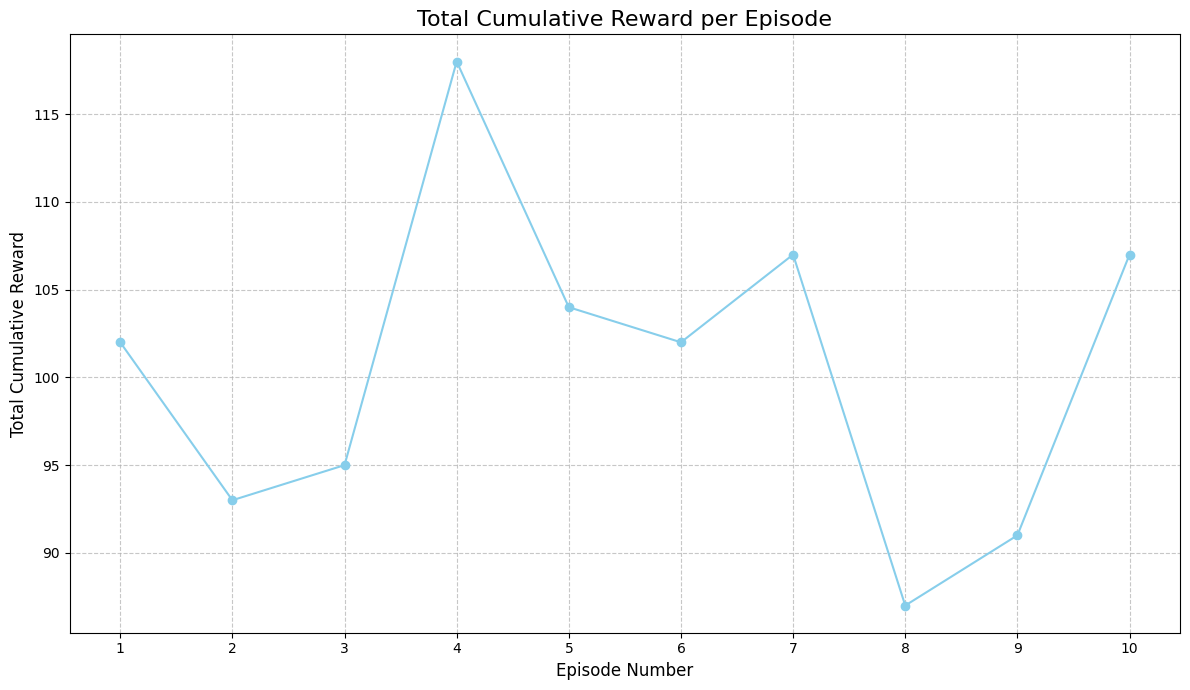


Plotting detailed dynamics for Episode 4...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


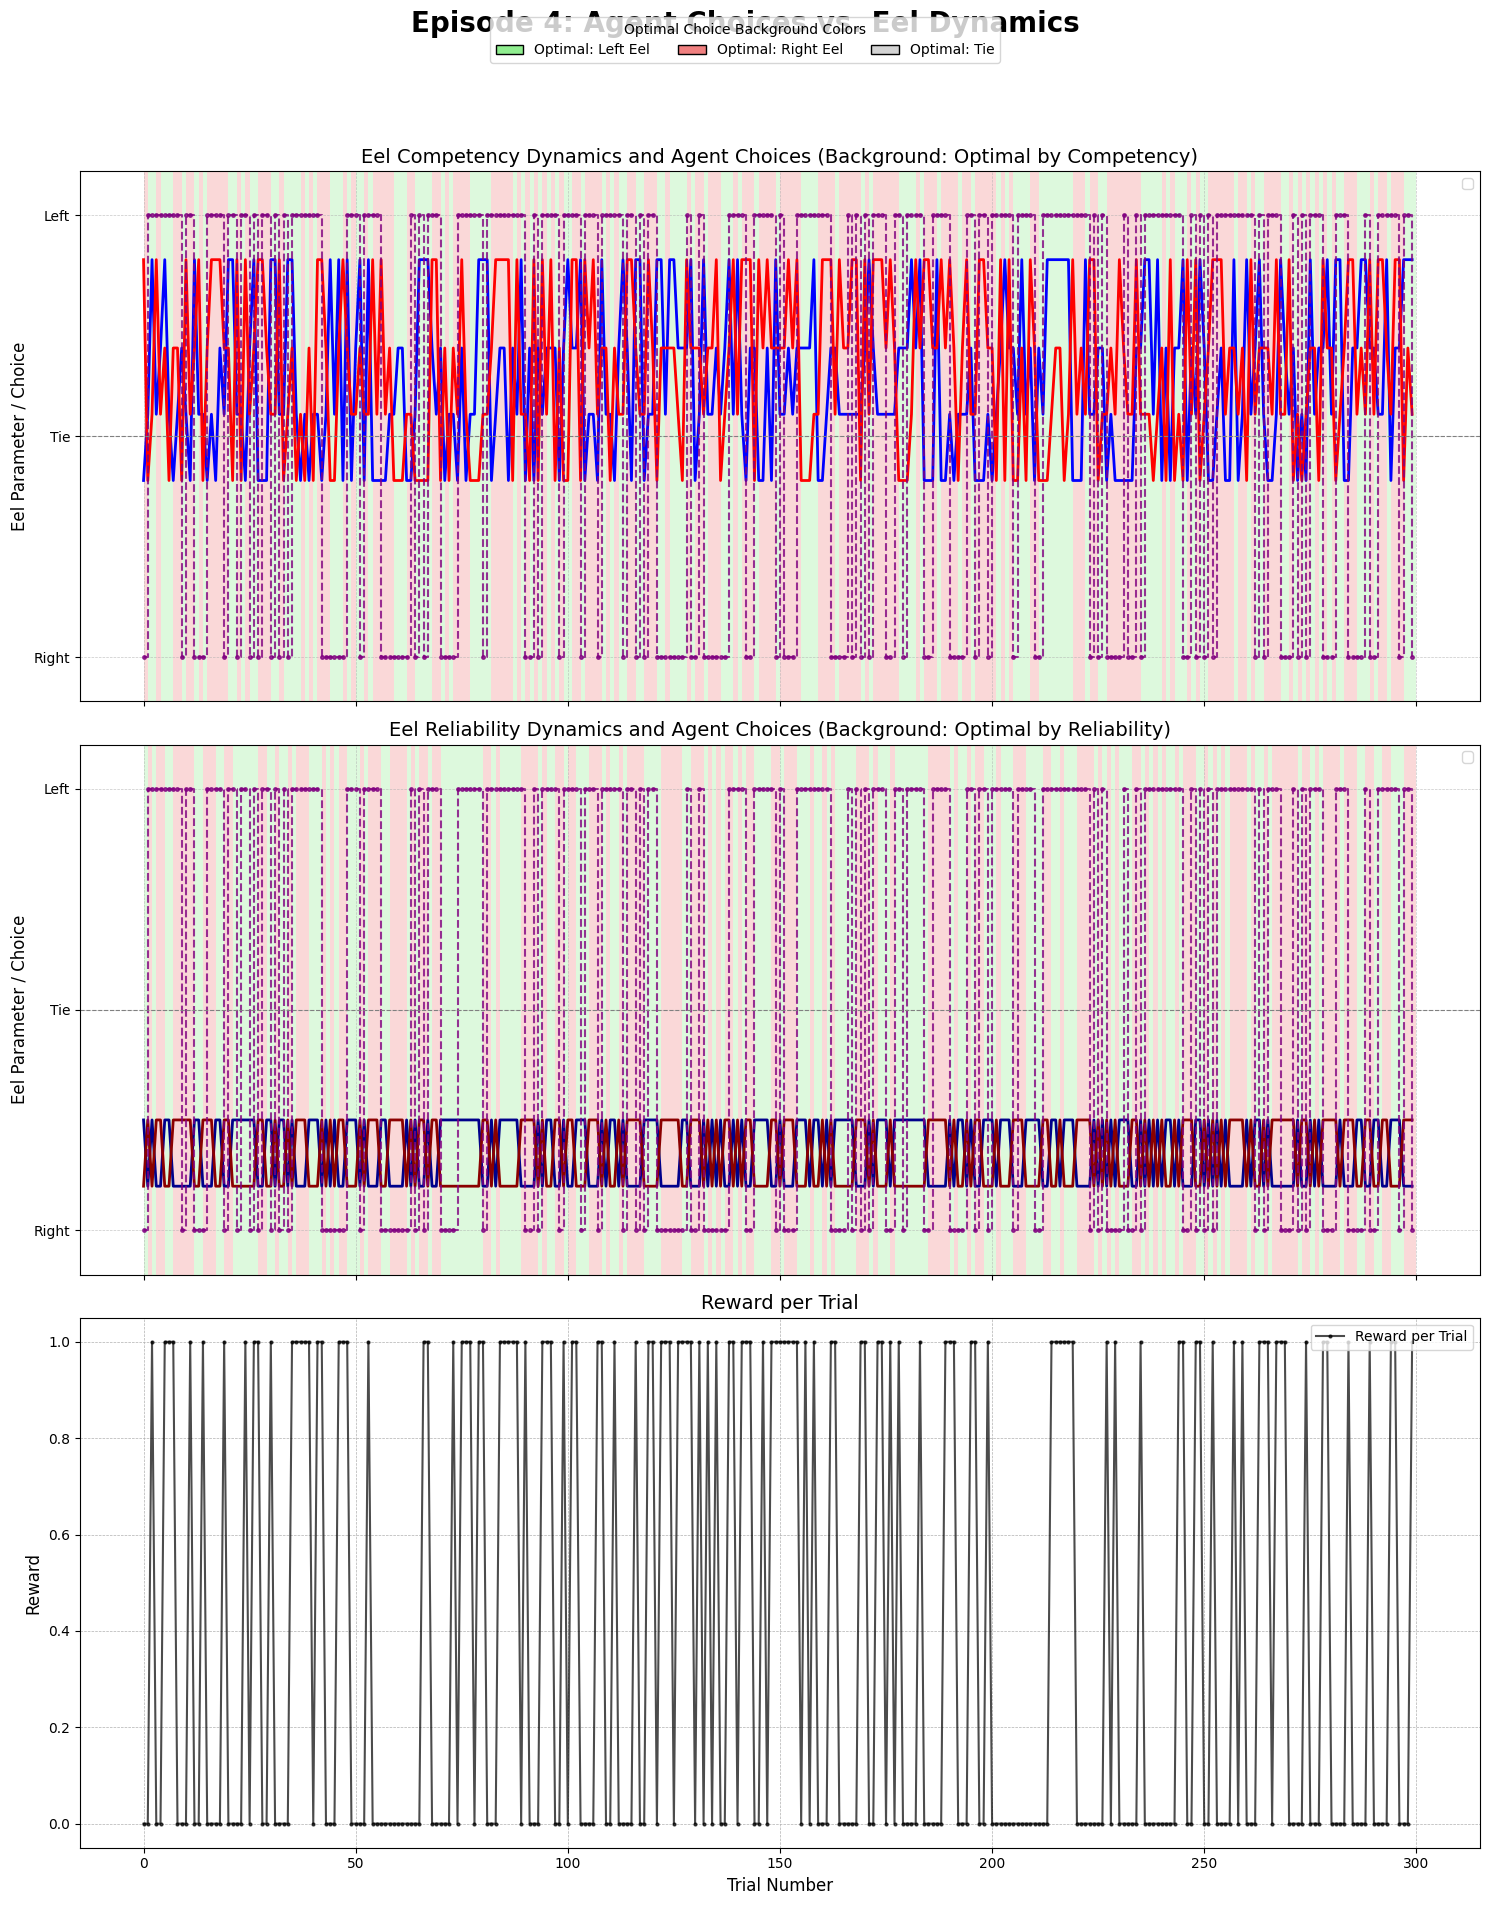

In [11]:
if __name__ == "__main__":
    # Define the range of episodes you trained
    analysis_start_episode = 1
    analysis_end_episode = 10 # Adjust based on your actual trained episodes

    # Load all available logs
    print(f"Loading logs for episodes {analysis_start_episode} to {analysis_end_episode}...")
    all_logs = load_all_episode_logs(
        log_dir="train_log",
        start_episode=analysis_start_episode,
        end_episode=analysis_end_episode
    )
    print(f"Loaded logs for {len(all_logs)} episodes.")

    # --- Plot 1: Cumulative Rewards Across All Episodes ---
    if all_logs:
        plot_cumulative_rewards_per_episode(all_logs)
    else:
        print("No logs loaded to plot cumulative rewards across episodes.")

    # --- Plot 2: Detailed Dynamics for a Single Selected Episode ---
    # IMPORTANT: Change this value to the episode number you want to inspect closely!
    episode_to_visualize = 4

    if episode_to_visualize in all_logs and all_logs[episode_to_visualize]:
        print(f"\nPlotting detailed dynamics for Episode {episode_to_visualize}...")
        plot_agent_vs_true_dynamics(all_logs, episode_to_visualize)
    else:
        print(f"No valid data for Episode {episode_to_visualize} found to plot detailed dynamics.")

## DQN

In [12]:
# --- Neural Network for Q-Function Approximation ---
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [13]:
# --- Experience Replay Buffer ---
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [14]:
# --- DQN Agent Class ---
class DQNAgent:
    def __init__(self, state_size, action_size, seed,
                 buffer_size=int(1e5), batch_size=64, gamma=0.99, lr=5e-4,
                 update_every=4, target_update_freq=100):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.gamma = gamma
        self.lr = lr
        self.update_every = update_every
        self.target_update_freq = target_update_freq

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        self.memory = ReplayBuffer(buffer_size, batch_size, seed)
        self.t_step = 0

        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

        # Update target network
        if (self.t_step + self.memory.batch_size) % self.target_update_freq == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())


    def choose_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > self.epsilon:
            return np.argmax(action_values.cpu().data.numpy()).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


    def save_checkpoint(self, path):
        """Saves the agent's models and epsilon state."""
        torch.save({
            'qnetwork_local_state_dict': self.qnetwork_local.state_dict(),
            'qnetwork_target_state_dict': self.qnetwork_target.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            't_step': self.t_step
        }, path)

    def load_checkpoint(self, path):
        """Loads the agent's models and epsilon state from a checkpoint."""
        if os.path.exists(path):
            checkpoint = torch.load(path, map_location=self.device)
            self.qnetwork_local.load_state_dict(checkpoint['qnetwork_local_state_dict'])
            self.qnetwork_target.load_state_dict(checkpoint['qnetwork_target_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.epsilon = checkpoint['epsilon']
            self.t_step = checkpoint['t_step']
            return True
        return False

In [15]:
# --- Main Training Loop for DQN Agent ---
def train_dqn_agent(num_episodes, data_folder_prefix,
                    checkpoint_dir="dqn_checkpoints", log_dir="dqn_train_logs",
                    state_size=4, action_size=2, seed=0,
                    buffer_size=int(1e3), batch_size=8, gamma=0.99, lr=5e-4,
                    update_every=4, target_update_freq=100):
    
    # Create distinct directories for DQN results
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    # Initialize DQN Agent
    agent = DQNAgent(state_size, action_size, seed, buffer_size, batch_size, gamma, lr, update_every, target_update_freq)

    print(f"DQN Training initiated. Saving checkpoints to '{checkpoint_dir}' and logs to '{log_dir}'.")

    for episode_num in range(1, num_episodes + 1):
        print(f"\n--- Starting DQN Training for Episode {episode_num} ---")
        
        # Determine data folder for current episode
        current_data_folder = f"{data_folder_prefix}/episode{episode_num}"
        
        # Initialize environment for the current episode
        try:
            env = EelEnv(data_folder=current_data_folder)
        except FileNotFoundError as e:
            print(f"Skipping episode {episode_num}: {e}")
            continue

        # Reset episode-specific metrics for tracking current episode's performance
        total_reward_current_episode = 0
        trial_log_current_episode = [] # To store details per trial for this episode

        done = False
        trial_idx = 0

        # Loop through trials within the current episode
        while not done:
            trial_idx += 1
            
            # Check if current trial data is valid before processing
            if not env.eels_info:
                print(f"  No eel info loaded for trial {trial_idx} in episode {episode_num}, ending episode prematurely.")
                done = True
                break

            left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
            right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)

            current_state_array = np.array([
                env.eels_info[left_idx]['competency'],
                env.eels_info[left_idx]['reliability'],
                env.eels_info[right_idx]['competency'],
                env.eels_info[right_idx]['reliability'],
            ], dtype=np.float32)

            action = agent.choose_action(current_state_array)

            reward, done, info = env.step(action)
            total_reward_current_episode += reward

            if not done:
                next_left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
                next_right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)
                next_state_array = np.array([
                    env.eels_info[next_left_idx]['competency'],
                    env.eels_info[next_left_idx]['reliability'],
                    env.eels_info[next_right_idx]['competency'],
                    env.eels_info[next_right_idx]['reliability'],
                ], dtype=np.float32)
            else:
                next_state_array = np.zeros(state_size, dtype=np.float32)
            
            agent.step(current_state_array, action, reward, next_state_array, done)

            trial_log_current_episode.append({
                'state': current_state_array.tolist(),
                'action': action,
                'reward': reward,
                'chosen_side': info['chosen_side'],
                'eel_color': env.color_name(info['eel_color']),
                'competency': info['competency'],
                'reliability': info['reliability'],
                'num_fish_caught': info['num_fish_caught'],
                'reward_prob': info['reward_prob']
            })

        print(f"Episode {episode_num} finished. Total Reward: {total_reward_current_episode:.2f}, Epsilon: {agent.epsilon:.4f}")

        agent.save_checkpoint(os.path.join(checkpoint_dir, f'dqn_episode{episode_num}.pth'))

        log_path = os.path.join(log_dir, f"dqn_episode{episode_num}_log.pkl")
        with open(log_path, 'wb') as f:
            pickle.dump(trial_log_current_episode, f)

    print("\nDQN Training Complete.")

In [16]:
# --- Plotting Functions ---

def load_all_episode_logs(log_dir="dqn_train_logs", start_episode=1, end_episode=10):
    """
    Loads trial logs for all episodes within the specified range from the DQN log directory.
    """
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"dqn_episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    # Check if the loaded data is directly the list of trials or wrapped in a dict
                    if isinstance(episode_data, dict) and ep_num in episode_data:
                        all_logs[ep_num] = episode_data.get(ep_num)
                    else:
                        all_logs[ep_num] = episode_data # Assume it's directly the list
            except Exception as e:
                print(f"Error loading log for episode {ep_num}: {e}")
    return all_logs

def plot_cumulative_rewards_per_episode(all_episode_logs):
    """
    Plots the total cumulative reward for each episode.
    """
    episode_numbers = sorted(all_episode_logs.keys())
    final_cumulative_rewards = []

    for ep_num in episode_numbers:
        trial_log = all_episode_logs.get(ep_num)
        if not trial_log:
            final_cumulative_rewards.append(0)
            continue

        current_cumulative_reward = 0
        for trial_details in trial_log: # trial_log is a list of dicts
            current_cumulative_reward += trial_details['reward']
        final_cumulative_rewards.append(current_cumulative_reward)

    if not episode_numbers:
        print("No episode data to plot cumulative rewards.")
        return

    plt.figure(figsize=(12, 7))
    plt.plot(episode_numbers, final_cumulative_rewards, marker='o', linestyle='-', color='skyblue')
    plt.title('DQN Total Cumulative Reward per Episode', fontsize=16)
    plt.xlabel('Episode Number', fontsize=12)
    plt.ylabel('Total Cumulative Reward', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(episode_numbers)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()

def plot_agent_vs_true_dynamics(all_episode_logs, selected_episode_num):
    """
    Plots the dynamics of eel competency/reliability, and the agent's choices
    against the 'true' optimal choice (shown as background color) for a single episode.
    """
    if selected_episode_num not in all_episode_logs or not all_episode_logs[selected_episode_num]:
        print(f"Error: No valid data found for Episode {selected_episode_num}. Cannot generate detailed dynamics plot.")
        return

    trial_log = all_episode_logs[selected_episode_num]
    
    trials = []
    left_comp_values = []
    right_comp_values = []
    left_rel_values = []
    right_rel_values = []
    agent_choices = [] # 0 for Left, 1 for Right
    true_optimal_comp_choices = [] # 0 for Left, 1 for Right, 0.5 for Tie
    true_optimal_rel_choices = []  # 0 for Left, 1 for Right, 0.5 for Tie
    rewards = [] # Immediate rewards per trial

    for trial_idx, trial_details in enumerate(trial_log):
        trials.append(trial_idx)
        state_list = trial_details['state']
        left_comp, left_rel, right_comp, right_rel = state_list

        left_comp_values.append(left_comp)
        right_comp_values.append(right_comp)
        left_rel_values.append(left_rel)
        right_rel_values.append(right_rel)
        agent_choices.append(trial_details['action'])

        rewards.append(trial_details['reward'])

        if left_comp > right_comp:
            true_optimal_comp_choices.append(0) # Left is better (action 0)
        elif right_comp > left_comp:
            true_optimal_comp_choices.append(1) # Right is better (action 1)
        else:
            true_optimal_comp_choices.append(0.5) # Tie

        if left_rel > right_rel:
            true_optimal_rel_choices.append(0) # Left is better (action 0)
        elif right_rel > left_rel:
            true_optimal_rel_choices.append(1) # Right is better (action 1)
        else:
            true_optimal_rel_choices.append(0.5) # Tie

    # Define background colors for clarity
    COLOR_LEFT = 'lightgreen'
    COLOR_RIGHT = 'lightcoral'
    COLOR_TIE = 'lightgray'

    fig, axs = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
    fig.suptitle(f'DQN Episode {selected_episode_num}: Agent Choices vs. Eel Dynamics', fontsize=20, weight='bold')

    def apply_background_colors(ax, true_choices, trial_len, title):
        prev_choice = None
        start_trial = 0
        for i in range(trial_len):
            current_choice = true_choices[i]
            if current_choice != prev_choice:
                if prev_choice is not None:
                    color = COLOR_LEFT if prev_choice == 0 else (COLOR_RIGHT if prev_choice == 1 else COLOR_TIE)
                    ax.axvspan(start_trial, i, facecolor=color, alpha=0.3)
                start_trial = i
                prev_choice = current_choice
        if prev_choice is not None:
            color = COLOR_LEFT if prev_choice == 0 else (COLOR_RIGHT if prev_choice == 1 else COLOR_TIE)
            ax.axvspan(start_trial, trial_len, facecolor=color, alpha=0.3)
        
        ax.set_title(title, fontsize=14)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        ax.legend(loc='upper right', fontsize=10)
        ax.set_ylabel('Eel Parameter / Choice', fontsize=12)


    # Plot 1: Competency Dynamics and Agent Choices
    apply_background_colors(axs[0], true_optimal_comp_choices, len(trials), 'Eel Competency Dynamics and Agent Choices (Background: Optimal by Competency)')
    axs[0].plot(trials, left_comp_values, label='Left Eel Competency', color='blue', linestyle='-', linewidth=2)
    axs[0].plot(trials, right_comp_values, label='Right Eel Competency', color='red', linestyle='-', linewidth=2)
    axs[0].plot(trials, [1-ac for ac in agent_choices], 
                label='Agent\'s Actual Choice', color='purple', marker='.', linestyle='--', drawstyle='steps-post', alpha=0.8, markersize=5)
    
    axs[0].set_yticks([0, 0.5, 1])
    axs[0].set_yticklabels(['Right', 'Tie', 'Left'])
    axs[0].axhline(0.5, color='grey', linestyle='--', linewidth=0.8)
    axs[0].set_ylim(-0.1, 1.1)


    # Plot 2: Reliability Dynamics and Agent Choices
    apply_background_colors(axs[1], true_optimal_rel_choices, len(trials), 'Eel Reliability Dynamics and Agent Choices (Background: Optimal by Reliability)')
    axs[1].plot(trials, left_rel_values, label='Left Eel Reliability', color='darkblue', linestyle='-', linewidth=2)
    axs[1].plot(trials, right_rel_values, label='Right Eel Reliability', color='darkred', linestyle='-', linewidth=2)
    axs[1].plot(trials, [1-ac for ac in agent_choices],
                label='Agent\'s Actual Choice', color='purple', marker='.', linestyle='--', drawstyle='steps-post', alpha=0.8, markersize=5)

    axs[1].set_yticks([0, 0.5, 1])
    axs[1].set_yticklabels(['Right', 'Tie', 'Left'])
    axs[1].axhline(0.5, color='grey', linestyle='--', linewidth=0.8)
    axs[1].set_ylim(-0.1, 1.1)

    # Plot 3: Rewards
    axs[2].plot(trials, rewards, label='Reward per Trial', color='black', alpha=0.7, marker='.', markersize=4, linestyle='-')
    axs[2].set_ylabel('Reward', fontsize=12)
    axs[2].set_xlabel('Trial Number', fontsize=12)
    axs[2].set_title('Reward per Trial', fontsize=14)
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[2].legend(loc='upper right', fontsize=10)


    # Add a global legend for background colors
    legend_elements = [
        Patch(facecolor=COLOR_LEFT, edgecolor='black', label='Optimal: Left Eel'),
        Patch(facecolor=COLOR_RIGHT, edgecolor='black', label='Optimal: Right Eel'),
        Patch(facecolor=COLOR_TIE, edgecolor='black', label='Optimal: Tie')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98),
               ncol=3, title="Optimal Choice Background Colors", fontsize=10)


    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    plt.show()
    plt.close()

Starting DQN training process...
DQN Training initiated. Saving checkpoints to 'dqn_checkpoints' and logs to 'dqn_train_logs'.

--- Starting DQN Training for Episode 1 ---
Episode 1 finished. Total Reward: 99.00, Epsilon: 0.6936

--- Starting DQN Training for Episode 2 ---
Episode 2 finished. Total Reward: 99.00, Epsilon: 0.4762

--- Starting DQN Training for Episode 3 ---
Episode 3 finished. Total Reward: 114.00, Epsilon: 0.3270

--- Starting DQN Training for Episode 4 ---
Episode 4 finished. Total Reward: 122.00, Epsilon: 0.2245

--- Starting DQN Training for Episode 5 ---
Episode 5 finished. Total Reward: 126.00, Epsilon: 0.1542

--- Starting DQN Training for Episode 6 ---
Episode 6 finished. Total Reward: 116.00, Epsilon: 0.1059

--- Starting DQN Training for Episode 7 ---
Episode 7 finished. Total Reward: 140.00, Epsilon: 0.0727

--- Starting DQN Training for Episode 8 ---
Episode 8 finished. Total Reward: 130.00, Epsilon: 0.0499

--- Starting DQN Training for Episode 9 ---
Episod

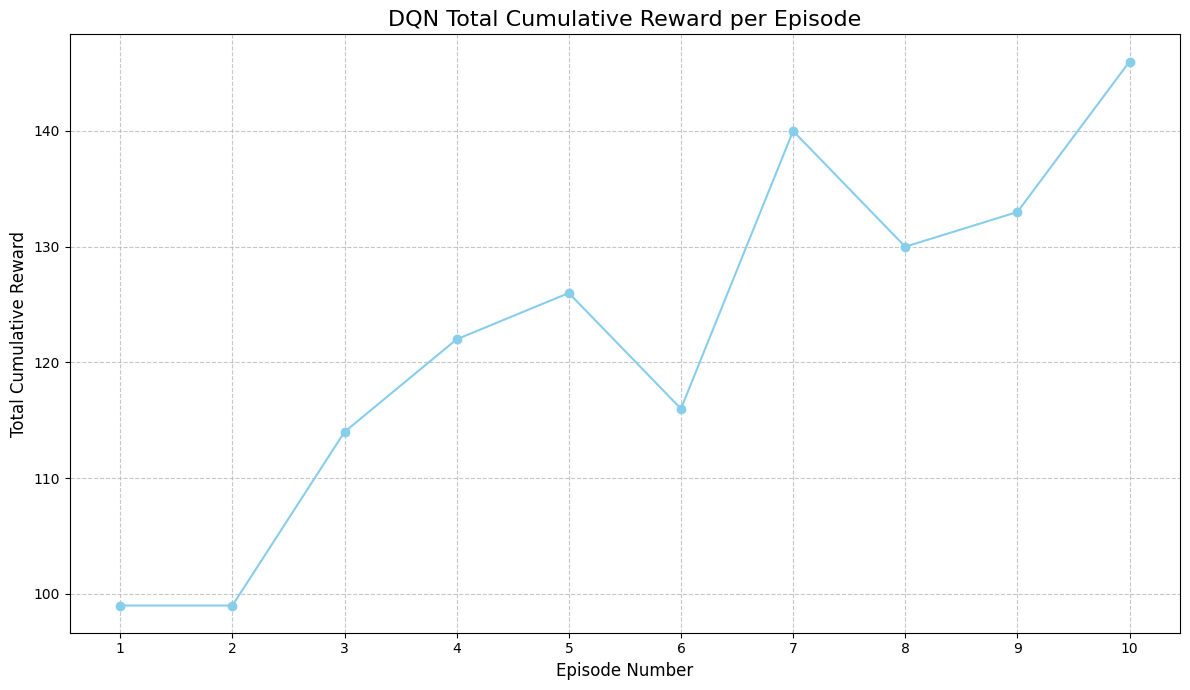

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'Patch' is not defined

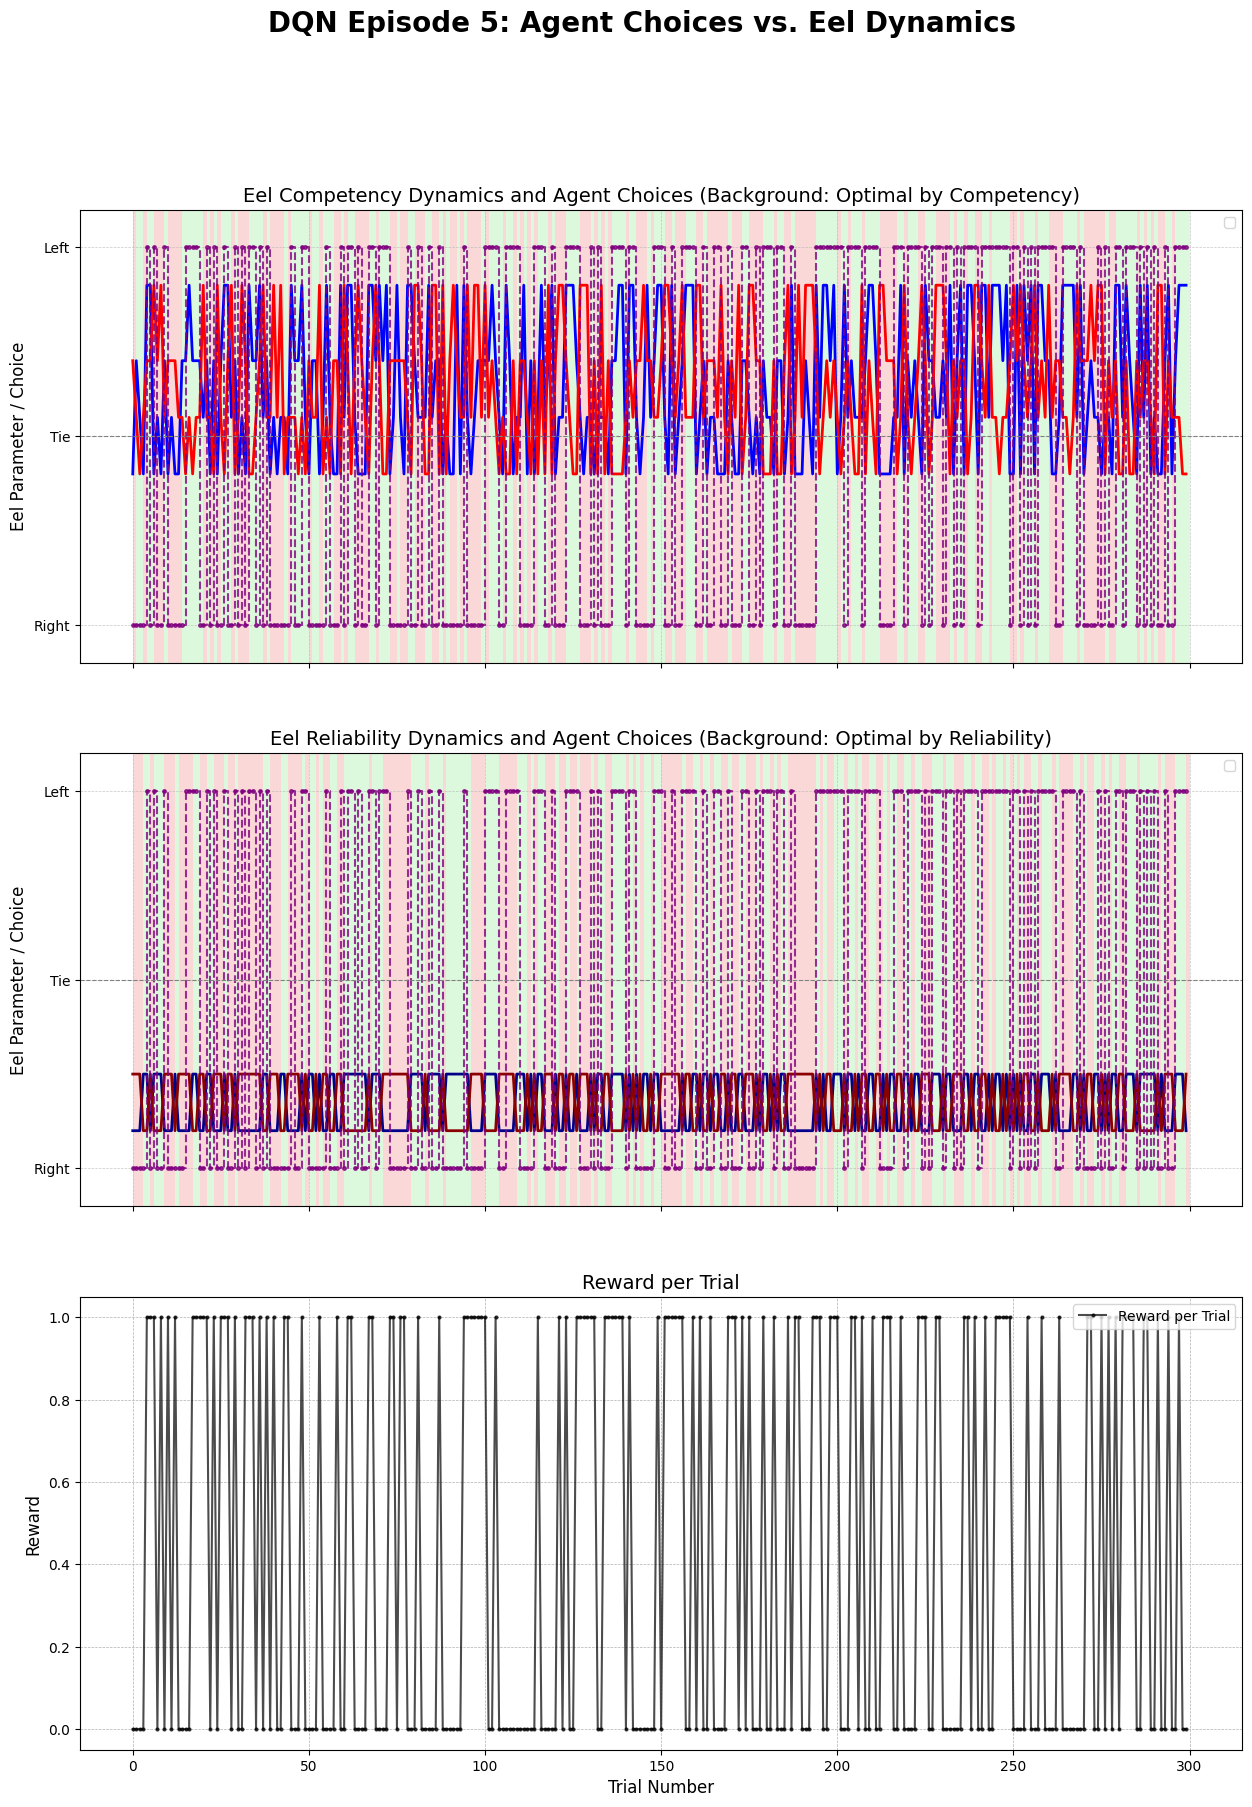

In [17]:
# --- Main Execution Block ---
if __name__ == "__main__":
    # Define the range of episodes you want to train
    NUM_EPISODES = 10 
    DATA_FOLDER_PREFIX = 'premade_eels/train' 

    # --- Run the DQN training ---
    print("Starting DQN training process...")
    train_dqn_agent(
        num_episodes=NUM_EPISODES,
        data_folder_prefix=DATA_FOLDER_PREFIX,
        # Default save directories are now 'dqn_checkpoints' and 'dqn_train_logs'
        checkpoint_dir="dqn_checkpoints",
        log_dir="dqn_train_logs",
        # Hyperparameters for DQN (tune as needed)
        buffer_size=int(1e3), 
        batch_size=8,       
        gamma=0.99,          
        lr=5e-4,             
        update_every=4,      
        target_update_freq=100
    )
    print("\nDQN Training session finished.")

    # --- Plotting after training ---
    print("\nGenerating plots from DQN training logs...")

    # Load logs (from the new DQN log directory)
    all_dqn_logs = load_all_episode_logs(start_episode=1, end_episode=NUM_EPISODES)

    # Plot 1: Cumulative Rewards Across All Episodes
    plot_cumulative_rewards_per_episode(all_dqn_logs)

    # Plot 2: Detailed Dynamics for a Single Selected Episode
    # IMPORTANT: Change this to an episode number you want to visualize
    dqn_episode_to_visualize = 5 
    if dqn_episode_to_visualize in all_dqn_logs and all_dqn_logs[dqn_episode_to_visualize]:
        plot_agent_vs_true_dynamics(all_dqn_logs, dqn_episode_to_visualize)
    else:
        print(f"No valid data for DQN Episode {dqn_episode_to_visualize} found to plot detailed dynamics.")


Generating plots from DQN training logs...


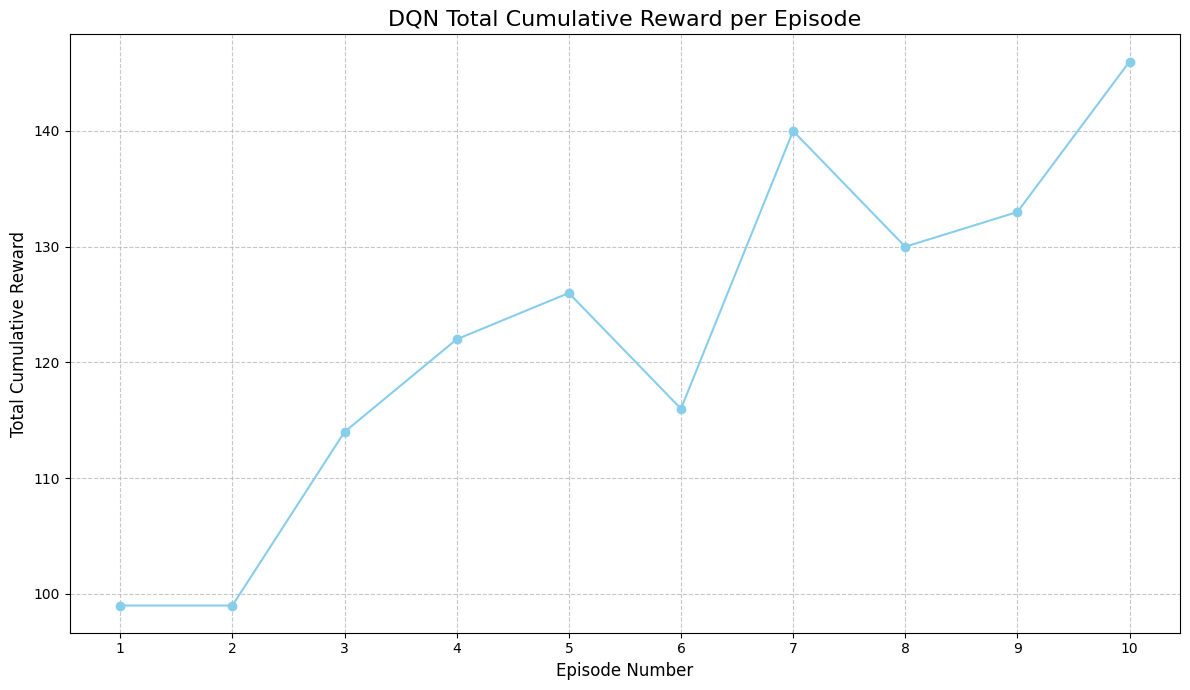

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


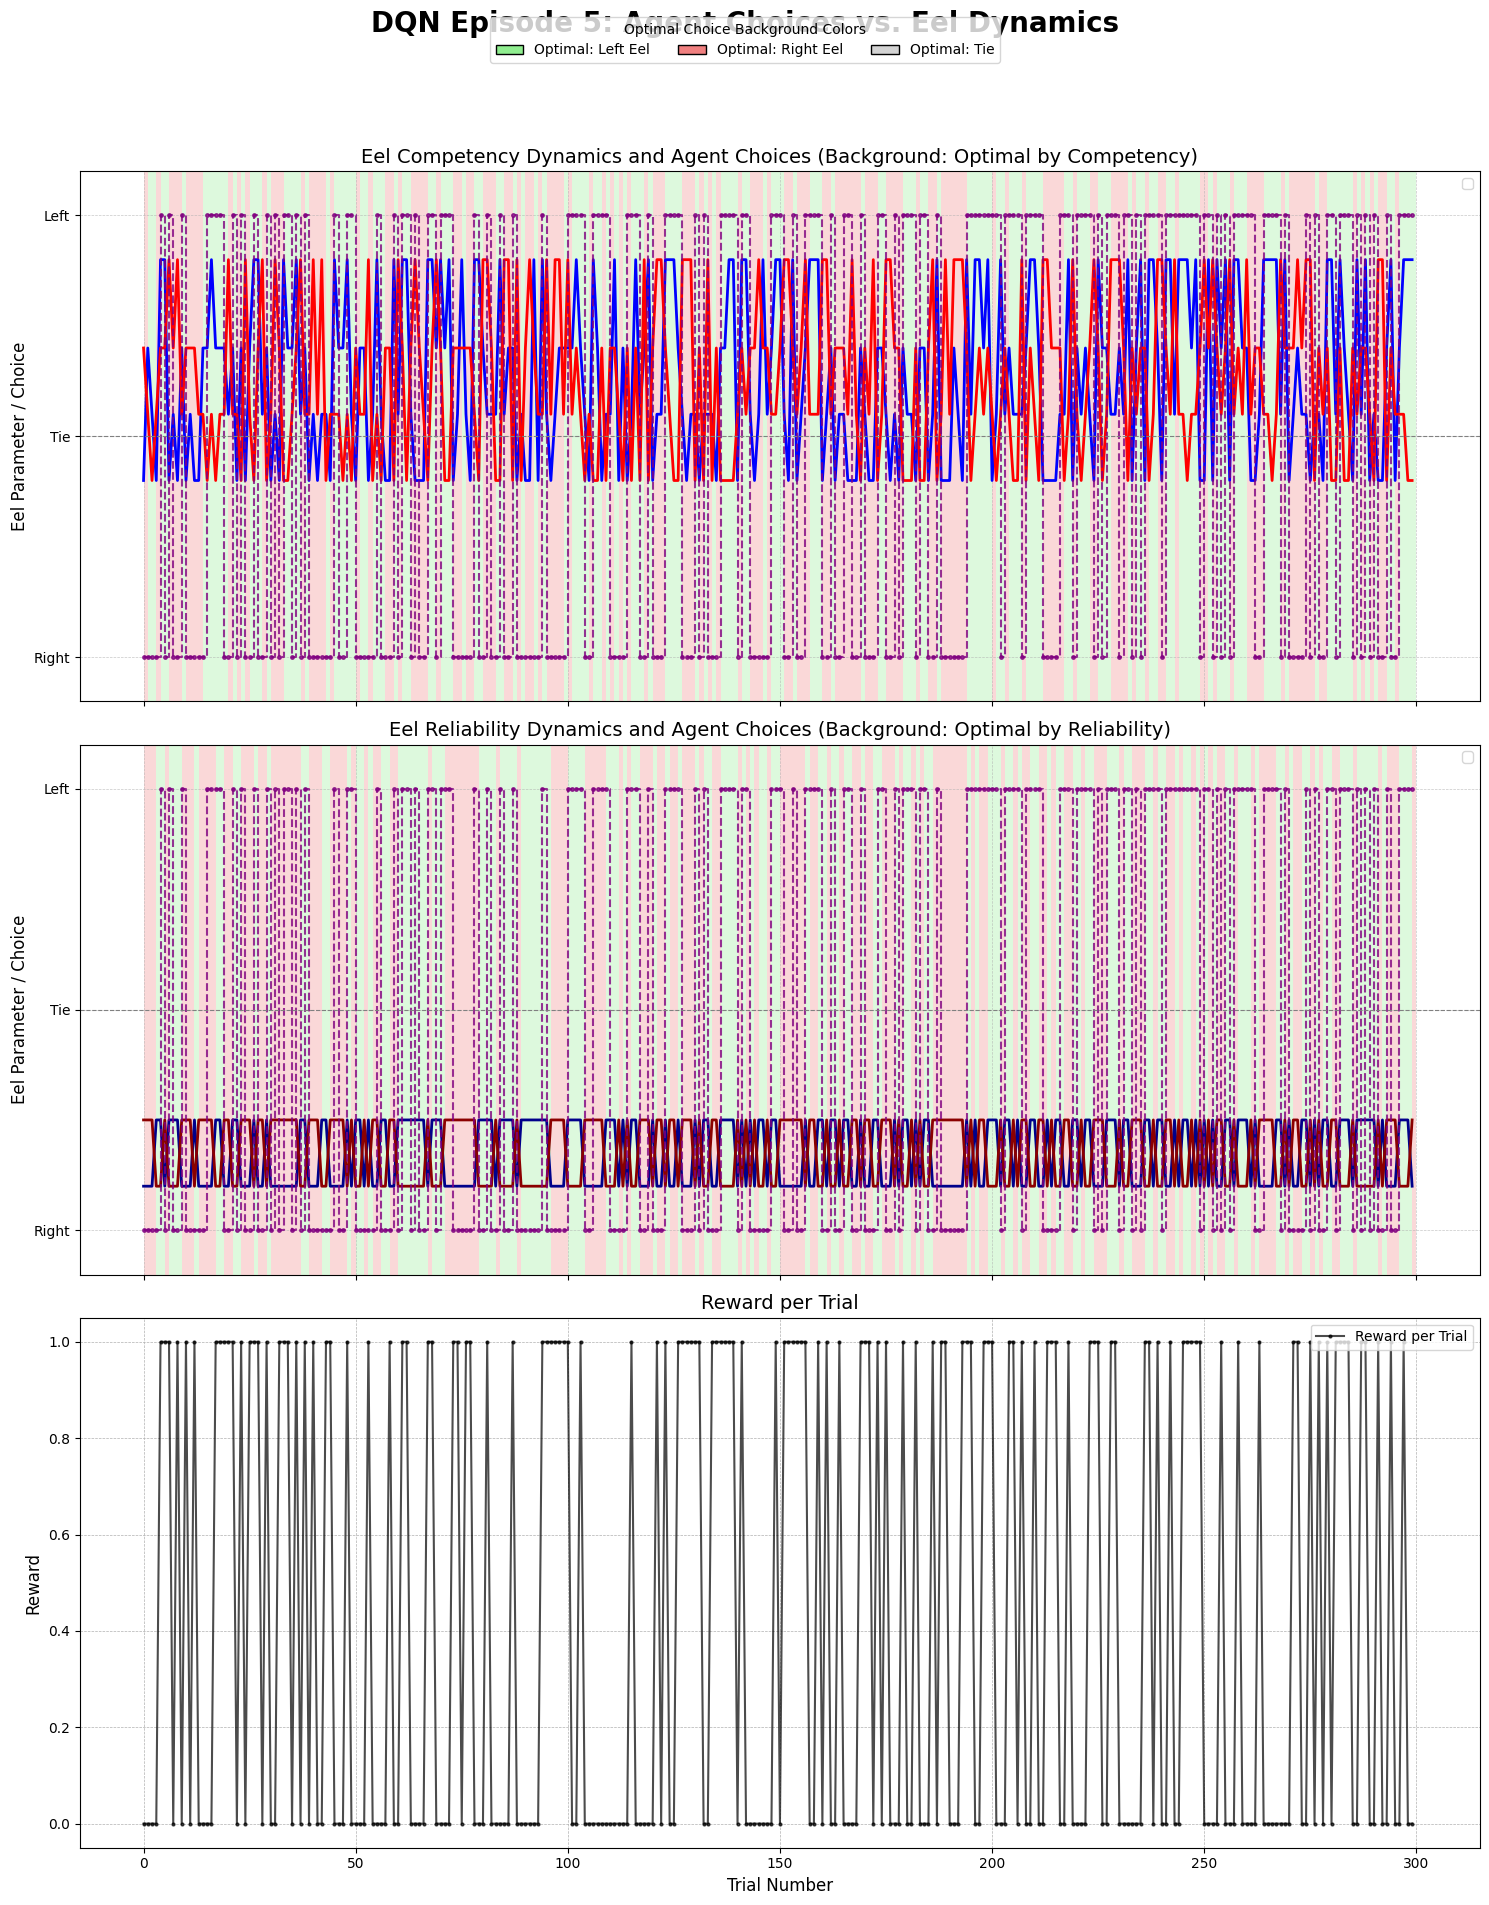

In [20]:
# --- Plotting after training ---
print("\nGenerating plots from DQN training logs...")

# Load logs (from the new DQN log directory)
all_dqn_logs = load_all_episode_logs(start_episode=1, end_episode=NUM_EPISODES)

# Plot 1: Cumulative Rewards Across All Episodes
plot_cumulative_rewards_per_episode(all_dqn_logs)

# Plot 2: Detailed Dynamics for a Single Selected Episode
# IMPORTANT: Change this to an episode number you want to visualize
dqn_episode_to_visualize = 5 
if dqn_episode_to_visualize in all_dqn_logs and all_dqn_logs[dqn_episode_to_visualize]:
    plot_agent_vs_true_dynamics(all_dqn_logs, dqn_episode_to_visualize)
else:
    print(f"No valid data for DQN Episode {dqn_episode_to_visualize} found to plot detailed dynamics.")

Loading Q-Learning logs from episode 1 to 10...
Loaded Q-Learning logs for 10 episodes.
Loading DQN logs from episode 1 to 10...
Loaded DQN logs for 10 episodes.


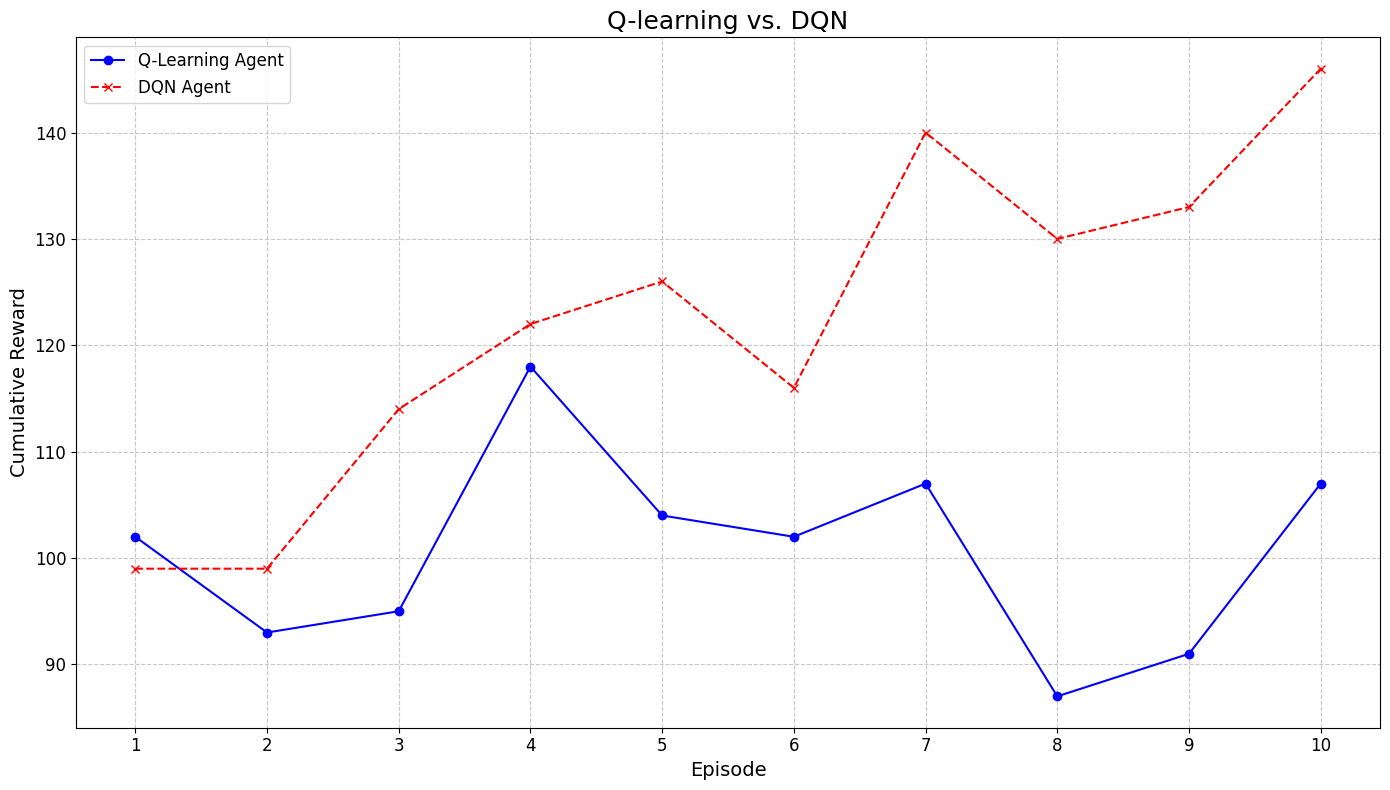

In [24]:
# --- 1. Functions to Load Logs ---

def load_q_learning_logs(log_dir="train_log", start_episode=1, end_episode=10):
    """
    Loads trial logs for the original Q-learning agent.
    Assumes logs are lists of tuples: (state, action, reward, color, chosen_side)
    """
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    # Original Q-learning log could be nested {ep_num: [trials]}
                    if isinstance(episode_data, dict) and ep_num in episode_data:
                        all_logs[ep_num] = episode_data.get(ep_num)
                    else:
                        all_logs[ep_num] = episode_data # Assume it's directly the list of logs
            except Exception as e:
                print(f"Error loading Q-Learning log for episode {ep_num}: {e}")
    return all_logs

def load_dqn_logs(log_dir="dqn_train_logs", start_episode=1, end_episode=10):
    """
    Loads trial logs for the DQN agent.
    Assumes logs are lists of dictionaries: {'state': [...], 'action': ..., 'reward': ...}
    """
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"dqn_episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    # DQN log is saved as a direct list of dictionaries for the episode
                    all_logs[ep_num] = episode_data
            except Exception as e:
                print(f"Error loading DQN log for episode {ep_num}: {e}")
    return all_logs

# --- 2. Plotting Comparison Function ---

def plot_agent_comparison_rewards(q_learning_logs, dqn_logs, title="Q-learning vs. DQN"):
    """
    Plots the total cumulative reward for Q-Learning and DQN agents on the same graph.

    Args:
        q_learning_logs (dict): Dictionary of loaded Q-Learning episode logs.
        dqn_logs (dict): Dictionary of loaded DQN episode logs.
        title (str): Title for the plot.
    """
    q_episode_numbers = sorted(q_learning_logs.keys())
    q_final_cumulative_rewards = []
    for ep_num in q_episode_numbers:
        trial_log = q_learning_logs.get(ep_num)
        if not trial_log:
            q_final_cumulative_rewards.append(0)
            continue
        current_cumulative_reward = 0
        # Original Q-learning log format is (state, action, reward, ...)
        for _, _, reward, _, _ in trial_log: 
            current_cumulative_reward += reward
        q_final_cumulative_rewards.append(current_cumulative_reward)

    dqn_episode_numbers = sorted(dqn_logs.keys())
    dqn_final_cumulative_rewards = []
    for ep_num in dqn_episode_numbers:
        trial_log = dqn_logs.get(ep_num)
        if not trial_log:
            dqn_final_cumulative_rewards.append(0)
            continue
        current_cumulative_reward = 0
        # DQN log format is a list of dictionaries {'reward': ...}
        for trial_details in trial_log: 
            current_cumulative_reward += trial_details['reward']
        dqn_final_cumulative_rewards.append(current_cumulative_reward)

    plt.figure(figsize=(14, 8))
    
    if q_episode_numbers:
        plt.plot(q_episode_numbers, q_final_cumulative_rewards, marker='o', linestyle='-', color='blue', label='Q-Learning Agent')
    else:
        print("Warning: No Q-Learning logs found to plot.")

    if dqn_episode_numbers:
        plt.plot(dqn_episode_numbers, dqn_final_cumulative_rewards, marker='x', linestyle='--', color='red', label='DQN Agent')
    else:
        print("Warning: No DQN logs found to plot.")

    plt.title(title, fontsize=18)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Cumulative Reward', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ensure x-ticks cover the full range of both agents' episodes
    all_episode_numbers = sorted(list(set(q_episode_numbers + dqn_episode_numbers)))
    if all_episode_numbers:
        plt.xticks(all_episode_numbers)

    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    # Define the range of episodes you trained for BOTH agents
    # Make sure these ranges match your actual generated log files
    ANALYSIS_START_EPISODE = 1
    ANALYSIS_END_EPISODE = 10 # Assuming both agents trained up to episode 10

    # Load logs for the original Q-Learning agent
    print(f"Loading Q-Learning logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    q_learning_logs = load_q_learning_logs(
        log_dir="train_log", # Your original Q-Learning log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded Q-Learning logs for {len(q_learning_logs)} episodes.")

    # Load logs for the DQN agent
    print(f"Loading DQN logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    dqn_logs = load_dqn_logs(
        log_dir="dqn_train_logs", # Your new DQN log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded DQN logs for {len(dqn_logs)} episodes.")

    # Plot the comparison
    plot_agent_comparison_rewards(q_learning_logs, dqn_logs)

In [66]:
# --- Plotting Detailed Dynamics for a Single Episode (Simplified Version) ---

def plot_agent_vs_true_dynamics_simplified(all_episode_logs, selected_episode_num, agent_type="DQN"):
    """
    Plots the true optimal choices (by competency and reliability) and the agent's actions
    for a single selected episode, along with rewards.

    Args:
        all_episode_logs (dict): Dictionary of loaded episode logs.
        selected_episode_num (int): The episode number to visualize.
        agent_type (str): "DQN" or "Q-Learning" to adjust log parsing and title.
    """
    is_dqn_log = (agent_type.lower() == "dqn")

    if selected_episode_num not in all_episode_logs or not all_episode_logs[selected_episode_num]:
        print(f"Error: No valid data found for {agent_type} Episode {selected_episode_num}. Cannot generate detailed dynamics plot.")
        return

    trial_log = all_episode_logs[selected_episode_num]
    
    trials = []
    agent_choices = [] # 0 for Left, 1 for Right
    true_optimal_comp_choices = [] # 0 for Left, 1 for Right, 0.5 for Tie
    true_optimal_rel_choices = []  # 0 for Left, 1 for Right, 0.5 for Tie
    rewards = [] # Immediate rewards per trial

    for trial_idx, trial_data in enumerate(trial_log):
        trials.append(trial_idx)
        
        if is_dqn_log:
            state_list = trial_data['state']
            action = trial_data['action']
            reward = trial_data['reward']
        else:
            state_list = trial_data[0] # state is the first element of the tuple
            action = trial_data[1]    # action is the second
            reward = trial_data[2]    # reward is the third

        left_comp, left_rel, right_comp, right_rel = state_list

        agent_choices.append(action)
        rewards.append(reward)

        # Determine the 'true' optimal choice based on competency
        if left_comp > right_comp:
            true_optimal_comp_choices.append(0) # Left is better (action 0)
        elif right_comp > left_comp:
            true_optimal_comp_choices.append(1) # Right is better (action 1)
        else:
            true_optimal_comp_choices.append(0.5) # Tie

        # Determine the 'true' optimal choice based on reliability
        if left_rel > right_rel:
            true_optimal_rel_choices.append(0) # Left is better (action 0)
        elif right_rel > left_rel:
            true_optimal_rel_choices.append(1) # Right is better (action 1)
        else:
            true_optimal_rel_choices.append(0.5) # Tie

    fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True) # Three subplots
    fig.suptitle(f'{agent_type} Episode {selected_episode_num}: Choices & Rewards', fontsize=20, weight='bold')

    # --- Subplot 1: Optimal Choice (Competency) vs. Agent's Action ---
    axs[0].plot(trials, [1-c for c in true_optimal_comp_choices], # Invert for Y-axis mapping: 1=Left, 0=Right
                label='Optimal Choice (by Competency)', color='green', linestyle='-', linewidth=3, drawstyle='steps-post')
    
    axs[0].plot(trials, [1-ac for ac in agent_choices], # Invert for Y-axis mapping: 1=Left, 0=Right
                label='Agent\'s Actual Choice', color='purple', marker='o', markersize=4, linestyle='--', drawstyle='steps-post', alpha=0.8)
    
    axs[0].set_ylabel('Choice', fontsize=12)
    axs[0].set_title('Optimal Choice (Competency) vs. Agent\'s Action', fontsize=14)
    axs[0].set_yticks([0, 0.5, 1])
    axs[0].set_yticklabels(['Right Eel', 'Tie', 'Left Eel']) # Clearer labels
    axs[0].axhline(0.5, color='grey', linestyle=':', linewidth=0.8) # Line for tie
    axs[0].legend(loc='upper right', fontsize=10)
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[0].set_ylim(-0.1, 1.1)


    # --- Subplot 2: Optimal Choice (Reliability) vs. Agent's Action ---
    axs[1].plot(trials, [1-r for r in true_optimal_rel_choices], # Invert for Y-axis mapping: 1=Left, 0=Right
                label='Optimal Choice (by Reliability)', color='orange', linestyle='-', linewidth=3, drawstyle='steps-post')

    axs[1].plot(trials, [1-ac for ac in agent_choices],
                label='Agent\'s Actual Choice', color='purple', marker='o', markersize=4, linestyle='--', drawstyle='steps-post', alpha=0.8)

    axs[1].set_ylabel('Choice', fontsize=12)
    axs[1].set_title('Optimal Choice (Reliability) vs. Agent\'s Action', fontsize=14)
    axs[1].set_yticks([0, 0.5, 1])
    axs[1].set_yticklabels(['Right Eel', 'Tie', 'Left Eel'])
    axs[1].axhline(0.5, color='grey', linestyle=':', linewidth=0.8)
    axs[1].legend(loc='upper right', fontsize=10)
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[1].set_ylim(-0.1, 1.1)

    # --- Subplot 3: Rewards ---
    axs[2].plot(trials, rewards, label='Reward per Trial', color='black', alpha=0.7, marker='.', markersize=4, linestyle='-')
    axs[2].set_ylabel('Reward', fontsize=12)
    axs[2].set_xlabel('Trial Number', fontsize=12)
    axs[2].set_title('Reward per Trial', fontsize=14)
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[2].legend(loc='upper right', fontsize=10)


    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout
    plt.show()
    plt.close()

In [67]:
# --- Psychometric Function Plotting Function (for a Single Episode) ---
def plot_psychometric_function_single_episode(all_episode_logs, selected_episode_num, agent_type="DQN", num_bins=20):
    """
    Plots the psychometric function for the agent for a *single chosen episode*,
    showing the probability of choosing the Left Eel as a function of the
    difference in competency and reliability.

    Args:
        all_episode_logs (dict): Dictionary of loaded episode logs (e.g., dqn_logs or q_learning_logs).
        selected_episode_num (int): The specific episode number to plot.
        agent_type (str): "DQN" or "Q-Learning" for plot title and log parsing.
        num_bins (int): Number of bins for the stimulus difference (x-axis).
    """
    is_dqn_log = (agent_type.lower() == "dqn")

    if selected_episode_num not in all_episode_logs or not all_episode_logs[selected_episode_num]:
        print(f"Error: No valid data found for {agent_type} Episode {selected_episode_num}. Cannot plot psychometric function.")
        return

    # Get data for the specific episode
    trial_log = all_episode_logs[selected_episode_num]

    comp_diffs = []
    rel_diffs = []
    left_choices = [] # 1 if agent chose left, 0 if chose right

    for trial_data in trial_log:
        if is_dqn_log:
            state_list = trial_data['state']
            action = trial_data['action']
        else:
            state_list = trial_data[0]
            action = trial_data[1]

        left_comp, left_rel, right_comp, right_rel = state_list

        comp_diff = left_comp - right_comp
        rel_diff = left_rel - right_rel

        comp_diffs.append(comp_diff)
        rel_diffs.append(rel_diff)

        # Agent chose Left (action 0) -> y-value is 1
        # Agent chose Right (action 1) -> y-value is 0
        left_choices.append(1 - action)
    
    if not comp_diffs:
        print(f"No trial data available in Episode {selected_episode_num} to plot psychometric function for {agent_type}.")
        return

    # Bin the data and calculate means
    # For competency
    # Linspace from -1.0 to 1.0 covers the full range of differences
    comp_bins = np.linspace(-1.0, 1.0, num_bins + 1)
    comp_bin_indices = np.digitize(comp_diffs, comp_bins)
    
    binned_comp_x = []
    binned_comp_y = []
    for i in range(1, num_bins + 1):
        indices_in_bin = np.where(comp_bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            avg_comp_diff = np.mean(np.array(comp_diffs)[indices_in_bin])
            prob_left_choice = np.mean(np.array(left_choices)[indices_in_bin])
            binned_comp_x.append(avg_comp_diff)
            binned_comp_y.append(prob_left_choice)

    # For reliability
    rel_bins = np.linspace(-1.0, 1.0, num_bins + 1)
    rel_bin_indices = np.digitize(rel_diffs, rel_bins)
    
    binned_rel_x = []
    binned_rel_y = []
    for i in range(1, num_bins + 1):
        indices_in_bin = np.where(rel_bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            avg_rel_diff = np.mean(np.array(rel_diffs)[indices_in_bin])
            prob_left_choice = np.mean(np.array(left_choices)[indices_in_bin])
            binned_rel_x.append(avg_rel_diff)
            binned_rel_y.append(prob_left_choice)

    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'{agent_type} Psychometric Function for Episode {selected_episode_num}', fontsize=18, weight='bold')

    # Plot for Competency Difference
    axs[0].scatter(binned_comp_x, binned_comp_y, color='blue', marker='o', s=100, label='Data Points')
    axs[0].plot(binned_comp_x, binned_comp_y, color='blue', linestyle='--', alpha=0.6) # Connect points
    axs[0].set_title('Based on Competency Difference (Left Eel - Right Eel)', fontsize=14)
    axs[0].set_xlabel('Competency Difference', fontsize=12)
    axs[0].set_ylabel('P(Choose Left Eel)', fontsize=12)
    axs[0].set_xlim(-1.05, 1.05)
    axs[0].set_ylim(-0.05, 1.05)
    axs[0].axvline(0, color='grey', linestyle='--', alpha=0.7) # Vertical line at 0 difference
    axs[0].axhline(0.5, color='grey', linestyle='--', alpha=0.7) # Horizontal line at 0.5 probability
    axs[0].grid(True, linestyle=':', alpha=0.6)
    axs[0].legend()

    # Plot for Reliability Difference
    axs[1].scatter(binned_rel_x, binned_rel_y, color='red', marker='x', s=100, label='Data Points')
    axs[1].plot(binned_rel_x, binned_rel_y, color='red', linestyle='--', alpha=0.6) # Connect points
    axs[1].set_title('Based on Reliability Difference (Left Eel - Right Eel)', fontsize=14)
    axs[1].set_xlabel('Reliability Difference', fontsize=12)
    axs[1].set_ylabel('P(Choose Left Eel)', fontsize=12)
    axs[1].set_xlim(-1.05, 1.05)
    axs[1].set_ylim(-0.05, 1.05)
    axs[1].axvline(0, color='grey', linestyle='--', alpha=0.7)
    axs[1].axhline(0.5, color='grey', linestyle='--', alpha=0.7)
    axs[1].grid(True, linestyle=':', alpha=0.6)
    axs[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

Loading Q-Learning logs from episode 1 to 10...
Loaded Q-Learning logs for 10 episodes.
Loading DQN logs from episode 1 to 10...
Loaded DQN logs for 10 episodes.

Attempting to generate detailed dynamics plot for Q-Learning Episode 5...


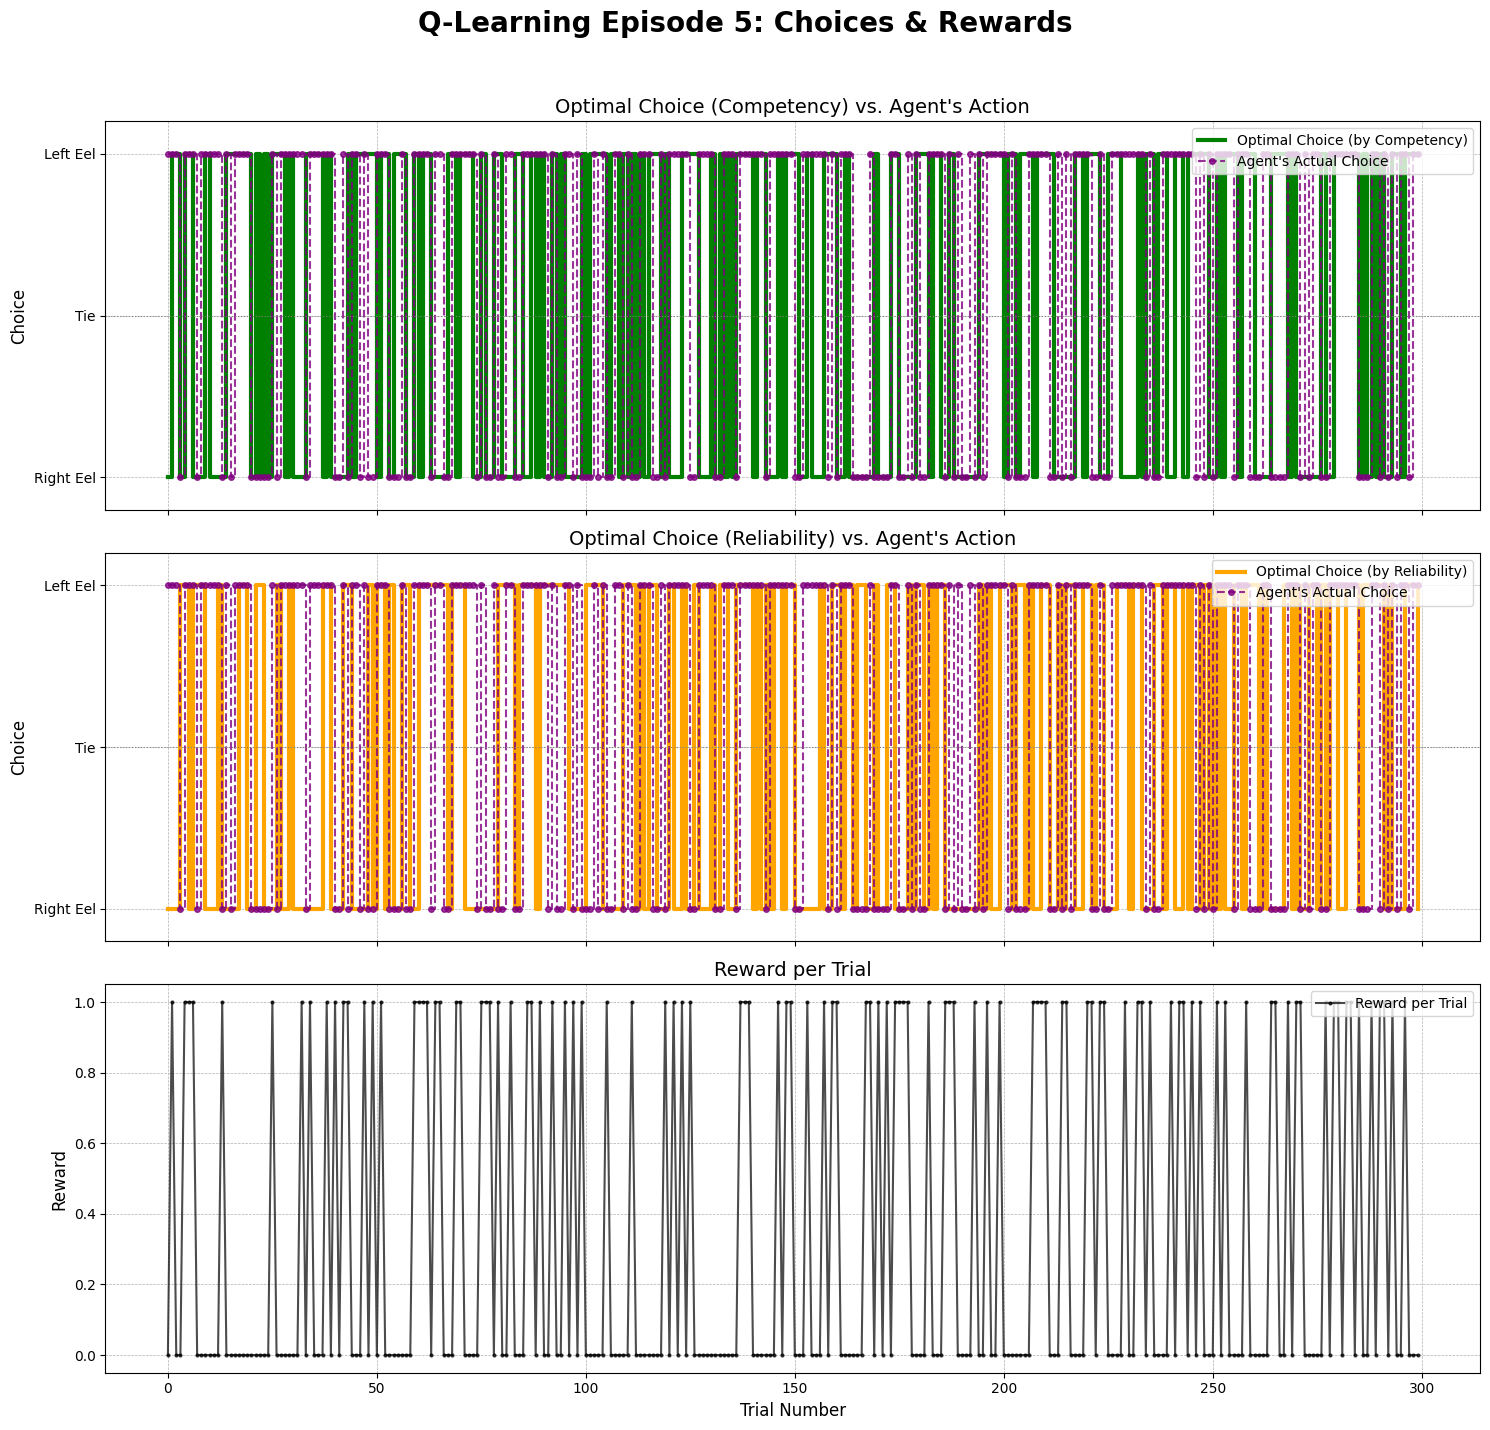


Generating psychometric function for DQN agent, Episode 5...


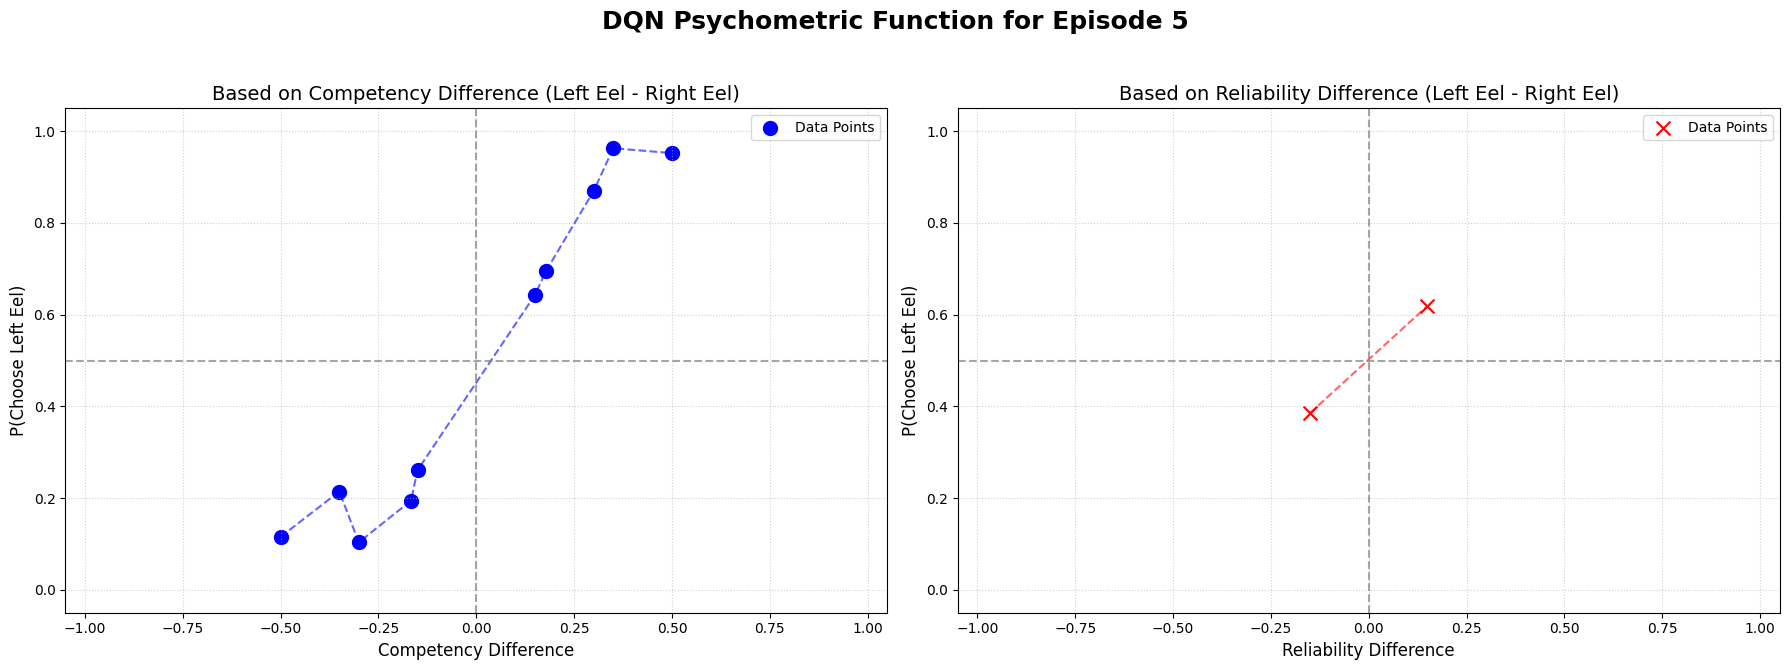

In [53]:
# --- Main Execution Block ---
if __name__ == "__main__":
    # Define the range of episodes you want to analyze
    ANALYSIS_START_EPISODE = 1
    ANALYSIS_END_EPISODE = 10 # Example: assuming you trained up to episode 10

    # --- Load logs for the original Q-Learning agent ---
    print(f"Loading Q-Learning logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    q_learning_logs = load_q_learning_logs(
        log_dir="train_log", # Your original Q-Learning log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded Q-Learning logs for {len(q_learning_logs)} episodes.")

    # --- Load logs for the DQN agent ---
    print(f"Loading DQN logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    dqn_logs = load_dqn_logs(
        log_dir="dqn_train_logs", # Your new DQN log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded DQN logs for {len(dqn_logs)} episodes.")

    # --- Configuration for the single-episode dynamics plot (still available) ---
    EPISODE_TO_VISUALIZE = 5     # The episode number to plot (e.g., 1, 2, 5, 10)
    AGENT_TYPE_FOR_DYNAMICS = "Q-Learning" # Choose "DQN" or "Q-Learning"
    
    print(f"\nAttempting to generate detailed dynamics plot for {AGENT_TYPE_FOR_DYNAMICS} Episode {EPISODE_TO_VISUALIZE}...")
    if AGENT_TYPE_FOR_DYNAMICS.lower() == "dqn":
        if EPISODE_TO_VISUALIZE in dqn_logs and dqn_logs[EPISODE_TO_VISUALIZE]:
            plot_agent_vs_true_dynamics_simplified(dqn_logs, EPISODE_TO_VISUALIZE, agent_type="DQN")
        else:
            print(f"No valid DQN data for Episode {EPISODE_TO_VISUALIZE} found.")
    elif AGENT_TYPE_FOR_DYNAMICS.lower() == "q-learning":
        if EPISODE_TO_VISUALIZE in q_learning_logs and q_learning_logs[EPISODE_TO_VISUALIZE]:
            plot_agent_vs_true_dynamics_simplified(q_learning_logs, EPISODE_TO_VISUALIZE, agent_type="Q-Learning")
        else:
            print(f"No valid Q-Learning data for Episode {EPISODE_TO_VISUALIZE} found.")
    else:
        print("Invalid AGENT_TYPE_FOR_DYNAMICS. Choose 'DQN' or 'Q-Learning'.")

    # --- Configuration for Psychometric Function Plot (for a Single Episode) ---
    # IMPORTANT: Adjust these two variables to select what you want to visualize
    EPISODE_TO_VISUALIZE = 5     # The specific episode number to plot
    AGENT_TYPE_TO_PLOT = "DQN"   # Choose "DQN" or "Q-Learning"
    NUM_BINS = 40               # Number of bins for the psychometric function (adjust for smoothness vs. data points)

    print(f"\nGenerating psychometric function for {AGENT_TYPE_TO_PLOT} agent, Episode {EPISODE_TO_VISUALIZE}...")
    if AGENT_TYPE_TO_PLOT.lower() == "dqn":
        plot_psychometric_function_single_episode(dqn_logs, EPISODE_TO_VISUALIZE, agent_type="DQN", num_bins=NUM_BINS)
    elif AGENT_TYPE_TO_PLOT.lower() == "q-learning":
        plot_psychometric_function_single_episode(q_learning_logs, EPISODE_TO_VISUALIZE, agent_type="Q-Learning", num_bins=NUM_BINS)
    else:
        print("Invalid AGENT_TYPE_TO_PLOT. Please choose 'DQN' or 'Q-Learning'.")

In [74]:
# --- Core Data Aggregation and Binning Function ---
def prepare_psychometric_data(episode_logs, agent_type="DQN", num_bins=20):
    """
    Prepares data for psychometric plotting from a given set of episode logs
    by binning stimulus differences and calculating probabilities.

    Args:
        episode_logs (dict or list): Either a dictionary of episode logs (for overall)
                                     or a list of trial data (for single episode).
        agent_type (str): "DQN" or "Q-Learning" to adjust log parsing.
        num_bins (int): Number of bins for the stimulus difference (x-axis).

    Returns:
        tuple: (binned_comp_x, binned_comp_y, binned_rel_x, binned_rel_y)
               or (None, None, None, None) if no data.
    """
    is_dqn_log = (agent_type.lower() == "dqn")

    all_comp_diffs = []
    all_rel_diffs = []
    all_left_choices = [] # 1 if agent chose left (action 0), 0 if chose right (action 1)

    # Determine if we're processing a single episode log or a dictionary of many
    if isinstance(episode_logs, dict): # Processing multiple episodes for overall
        for ep_num in sorted(episode_logs.keys()):
            trial_log = episode_logs.get(ep_num)
            if not trial_log:
                continue
            for trial_data in trial_log:
                if is_dqn_log:
                    state_list = trial_data['state']
                    action = trial_data['action']
                else:
                    state_list = trial_data[0]
                    action = trial_data[1]

                left_comp, left_rel, right_comp, right_rel = state_list
                all_comp_diffs.append(left_comp - right_comp)
                all_rel_diffs.append(left_rel - right_rel)
                all_left_choices.append(1 - action) # 1 for Left, 0 for Right
    elif isinstance(episode_logs, list): # Processing a single episode's list of trials
        trial_log = episode_logs
        for trial_data in trial_log:
            if is_dqn_log:
                state_list = trial_data['state']
                action = trial_data['action']
            else:
                state_list = trial_data[0]
                action = trial_data[1]
            
            left_comp, left_rel, right_comp, right_rel = state_list
            all_comp_diffs.append(left_comp - right_comp)
            all_rel_diffs.append(left_rel - right_rel)
            all_left_choices.append(1 - action) # 1 for Left, 0 for Right

    
    if not all_comp_diffs:
        return None, None, None, None

    # Common binning logic for both competency and reliability differences
    def bin_data(diffs, choices):
        bins = np.linspace(-1.0, 1.0, num_bins + 1)
        diffs_array = np.array(diffs)
        bin_indices = np.digitize(diffs_array, bins)
        
        binned_x = []
        binned_y = []
        for i in range(1, num_bins + 1):
            indices_in_bin = np.where(bin_indices == i)[0]
            if len(indices_in_bin) > 0:
                avg_diff = np.mean(diffs_array[indices_in_bin])
                prob_left_choice = np.mean(np.array(choices)[indices_in_bin])
                binned_x.append(avg_diff)
                binned_y.append(prob_left_choice)
        
        # Sort points for a smooth curve
        if binned_x: # Only sort if there's data
            binned_x, binned_y = zip(*sorted(zip(binned_x, binned_y)))
        return list(binned_x), list(binned_y) # Convert back to list for consistency

    binned_comp_x, binned_comp_y = bin_data(all_comp_diffs, all_left_choices)
    binned_rel_x, binned_rel_y = bin_data(all_rel_diffs, all_left_choices)

    return binned_comp_x, binned_comp_y, binned_rel_x, binned_rel_y


# --- Consolidated Plotting Function for Psychometric Comparison ---
def plot_compare_psychometric_functions_with_episodes(q_learning_logs, dqn_logs, num_bins=20):
    """
    Plots the psychometric functions for both Q-Learning and DQN agents on a single figure.
    Shows individual episode curves (more visible transparent) and overall average curves (prominent).
    Q-Learning is blue, DQN is red.
    """
    fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True) # Share Y-axis
    fig.suptitle('RL Psychometric function', fontsize=18)

    # --- Q-Learning Agent Plotting (Blue shades) ---
    # Plot individual episode curves for Q-Learning
    for ep_num, trial_log in q_learning_logs.items():
        comp_x_ep, comp_y_ep, rel_x_ep, rel_y_ep = prepare_psychometric_data(trial_log, agent_type="Q-Learning", num_bins=num_bins)
        if comp_x_ep:
            axs[0].plot(comp_x_ep, comp_y_ep, color='skyblue', linestyle='-', linewidth=1.0, alpha=0.6) # Clearer blue, slightly thicker
        if rel_x_ep:
            axs[1].plot(rel_x_ep, rel_y_ep, color='skyblue', linestyle='-', linewidth=1.0, alpha=0.6) # Clearer blue, slightly thicker
    
    # Plot overall average curve for Q-Learning
    q_comp_x_overall, q_comp_y_overall, q_rel_x_overall, q_rel_y_overall = prepare_psychometric_data(q_learning_logs, agent_type="Q-Learning", num_bins=num_bins)
    if q_comp_x_overall:
        axs[0].plot(q_comp_x_overall, q_comp_y_overall, color='blue', linestyle='-', linewidth=2.5, label='Q-Learning Overall Trend')
        axs[0].scatter(q_comp_x_overall, q_comp_y_overall, color='blue', marker='o', s=50, zorder=3)
    if q_rel_x_overall:
        axs[1].plot(q_rel_x_overall, q_rel_y_overall, color='blue', linestyle='-', linewidth=2.5, label='Q-Learning Overall Trend')
        axs[1].scatter(q_rel_x_overall, q_rel_y_overall, color='blue', marker='o', s=50, zorder=3)


    # --- DQN Agent Plotting (Red shades) ---
    # Plot individual episode curves for DQN
    for ep_num, trial_log in dqn_logs.items():
        comp_x_ep, comp_y_ep, rel_x_ep, rel_y_ep = prepare_psychometric_data(trial_log, agent_type="DQN", num_bins=num_bins)
        if comp_x_ep:
            axs[0].plot(comp_x_ep, comp_y_ep, color='lightcoral', linestyle='--', linewidth=1.0, alpha=0.6) # Clearer red, slightly thicker
        if rel_x_ep:
            axs[1].plot(rel_x_ep, rel_y_ep, color='lightcoral', linestyle='--', linewidth=1.0, alpha=0.6) # Clearer red, slightly thicker
    
    # Plot overall average curve for DQN
    dqn_comp_x_overall, dqn_comp_y_overall, dqn_rel_x_overall, dqn_rel_y_overall = prepare_psychometric_data(dqn_logs, agent_type="DQN", num_bins=num_bins)
    if dqn_comp_x_overall:
        axs[0].plot(dqn_comp_x_overall, dqn_comp_y_overall, color='red', linestyle='--', linewidth=2.5, label='DQN Overall Trend')
        axs[0].scatter(dqn_comp_x_overall, dqn_comp_y_overall, color='red', marker='x', s=50, zorder=3)
    if dqn_rel_x_overall:
        axs[1].plot(dqn_rel_x_overall, dqn_rel_y_overall, color='red', linestyle='--', linewidth=2.5, label='DQN Overall Trend')
        axs[1].scatter(dqn_rel_x_overall, dqn_rel_y_overall, color='red', marker='x', s=50, zorder=3)


    # --- Common Plot Settings ---
    axs[0].set_title('Competency', fontsize=14)
    axs[0].set_xlabel('Competency Difference (Left Eel - Right Eel)', fontsize=12)
    axs[0].set_ylabel('P(Choose Left Eel)', fontsize=12)
    axs[0].set_xlim(-1.05, 1.05)
    axs[0].set_ylim(-0.05, 1.05)
    axs[0].axvline(0, color='grey', linestyle='--', alpha=0.7)
    axs[0].axhline(0.5, color='grey', linestyle='--', alpha=0.7)
    axs[0].grid(True, linestyle=':', alpha=0.6)
    
    # Custom legend for better clarity
    legend_handles = [
        Line2D([0], [0], color='blue', linestyle='-', linewidth=2.5, label='Q-Learning Overall Trend', marker='o', markersize=6),
        Line2D([0], [0], color='skyblue', linestyle='-', linewidth=1.0, alpha=0.7, label='Q-Learning Individual Episodes'), # Adjusted alpha for clarity
        Line2D([0], [0], color='red', linestyle='--', linewidth=2.5, label='DQN Overall Trend', marker='x', markersize=6),
        Line2D([0], [0], color='lightcoral', linestyle='--', linewidth=1.0, alpha=0.7, label='DQN Individual Episodes') # Adjusted alpha for clarity
    ]
    axs[0].legend(handles=legend_handles, loc='upper left', fontsize=9)


    axs[1].set_title('Reliability', fontsize=14)
    axs[1].set_xlabel('Reliability Difference (Left Eel - Right Eel)', fontsize=12)
    axs[1].set_xlim(-1.05, 1.05)
    axs[1].set_ylim(-0.05, 1.05)
    axs[1].axvline(0, color='grey', linestyle='--', alpha=0.7)
    axs[1].axhline(0.5, color='grey', linestyle='--', alpha=0.7)
    axs[1].grid(True, linestyle=':', alpha=0.6)
    # Use the same legend handles for consistency across subplots
    axs[1].legend(handles=legend_handles, loc='upper left', fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

Loading Q-Learning logs from episode 1 to 10...
Loaded Q-Learning logs for 10 episodes.
Loading DQN logs from episode 1 to 10...
Loaded DQN logs for 10 episodes.


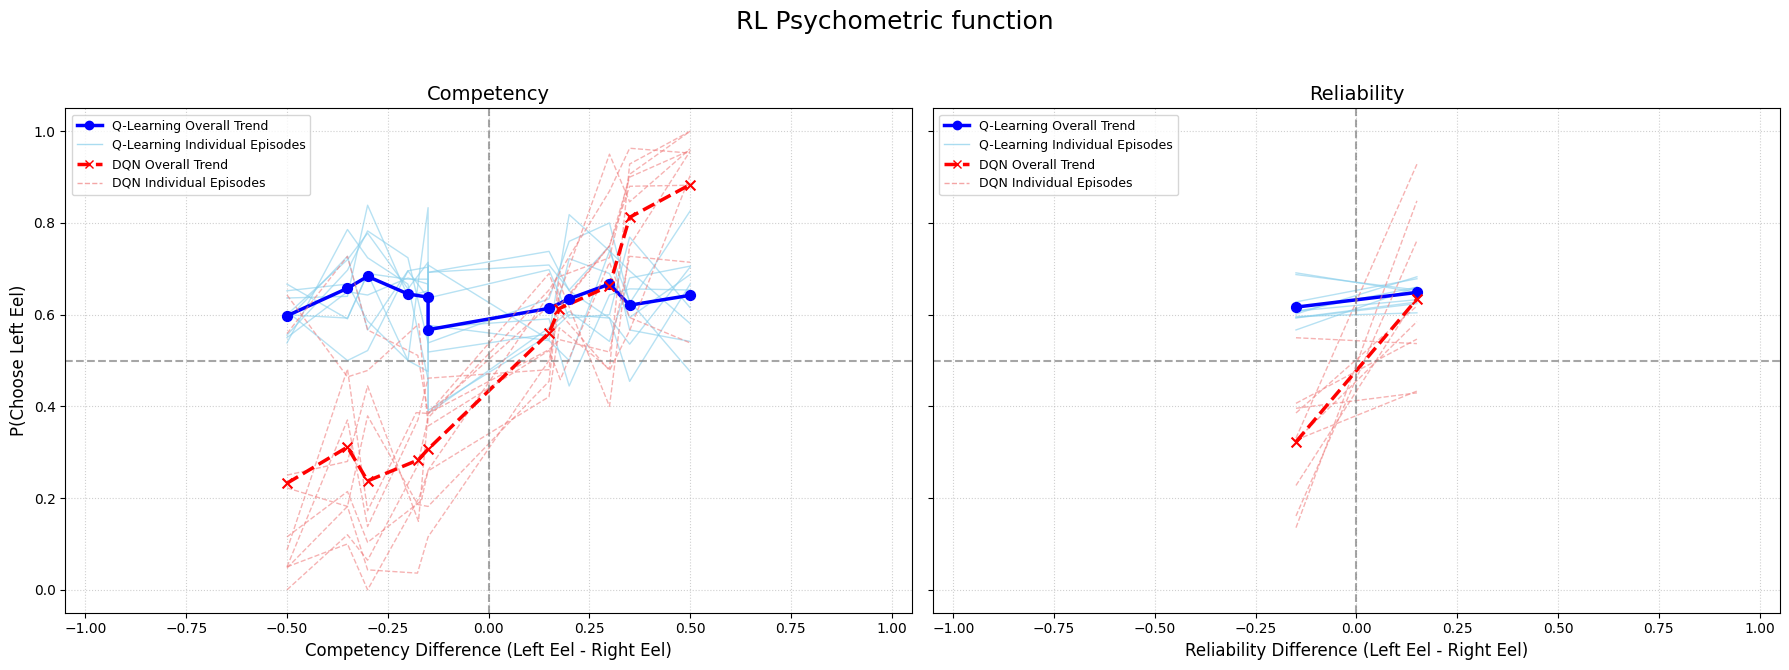

In [75]:
# --- Main Execution Block ---
if __name__ == "__main__":
    # Define the range of episodes you want to analyze
    ANALYSIS_START_EPISODE = 1
    ANALYSIS_END_EPISODE = 10 # Example: assuming you trained up to episode 10

    # --- Load logs for the original Q-Learning agent ---
    print(f"Loading Q-Learning logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    q_learning_logs = load_q_learning_logs(
        log_dir="train_log", # Your original Q-Learning log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded Q-Learning logs for {len(q_learning_logs)} episodes.")

    # --- Load logs for the DQN agent ---
    print(f"Loading DQN logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    dqn_logs = load_dqn_logs(
        log_dir="dqn_train_logs", # Your new DQN log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded DQN logs for {len(dqn_logs)} episodes.")

    # --- Generate Overall Psychometric Function for Comparison ---
    # Adjust NUM_BINS as needed for smoothness/granularity. 20 is a good starting point.
    plot_compare_psychometric_functions_with_episodes(q_learning_logs, dqn_logs, num_bins=40)

In [84]:
# --- Functions to Load Logs (from previous responses - unchanged) ---

def load_q_learning_logs(log_dir="train_log", start_episode=1, end_episode=10):
    """
    Loads trial logs for the original Q-learning agent.
    Assumes logs are lists of tuples: (state, action, reward, color, chosen_side)
    """
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    if isinstance(episode_data, dict) and ep_num in episode_data:
                        all_logs[ep_num] = episode_data.get(ep_num)
                    else:
                        all_logs[ep_num] = episode_data
            except Exception as e:
                print(f"Error loading Q-Learning log for episode {ep_num}: {e}")
        else:
            print(f"Q-Learning log file not found for episode {ep_num}: {log_path}")
    return all_logs

def load_dqn_logs(log_dir="dqn_train_logs", start_episode=1, end_episode=10):
    """
    Loads trial logs for the DQN agent.
    Assumes logs are lists of dictionaries: {'state': [...], 'action': ..., 'reward': ...}
    """
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"dqn_episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    all_logs[ep_num] = episode_data
            except Exception as e:
                print(f"Error loading DQN log for episode {ep_num}: {e}")
        else:
            print(f"DQN log file not found for episode {ep_num}: {log_path}")
    return all_logs

# --- New Function to Analyze Conflict Strategy ---
def analyze_conflict_strategy(all_agent_logs, agent_type="DQN"):
    """
    Analyzes how an agent makes choices when competency and reliability signals conflict.

    Args:
        all_agent_logs (dict): Dictionary of loaded episode logs for one agent type.
        agent_type (str): "DQN" or "Q-Learning" to adjust log parsing.

    Returns:
        tuple: (proportion_followed_comp, proportion_followed_rel)
               or (0, 0) if no conflict trials found.
    """
    is_dqn_log = (agent_type.lower() == "dqn")

    followed_competency_count = 0
    followed_reliability_count = 0
    total_conflict_trials = 0

    for ep_num in sorted(all_agent_logs.keys()):
        trial_log = all_agent_logs.get(ep_num)
        if not trial_log:
            continue

        for trial_data in trial_log:
            if is_dqn_log:
                state_list = trial_data['state']
                action = trial_data['action'] # 0 for Left, 1 for Right
            else:
                state_list = trial_data[0]
                action = trial_data[1] # 0 for Left, 1 for Right

            left_comp, left_rel, right_comp, right_rel = state_list

            comp_diff = left_comp - right_comp
            rel_diff = left_rel - right_rel

            # Define a conflict: when signs are opposite and neither is zero (for a clear signal)
            # A small epsilon for near-zero differences to avoid misclassifying true zeros as conflicts
            epsilon = 1e-6
            comp_favors_left = comp_diff > epsilon
            comp_favors_right = comp_diff < -epsilon
            rel_favors_left = rel_diff > epsilon
            rel_favors_right = rel_diff < -epsilon

            is_conflict = False
            if (comp_favors_left and rel_favors_right) or \
               (comp_favors_right and rel_favors_left):
                is_conflict = True

            if is_conflict:
                total_conflict_trials += 1
                
                # Determine what the agent chose
                agent_chose_left = (action == 0)
                agent_chose_right = (action == 1)

                # Case 1: Competency favors Left, Reliability favors Right
                if comp_favors_left and rel_favors_right:
                    if agent_chose_left:
                        followed_competency_count += 1
                    elif agent_chose_right:
                        followed_reliability_count += 1
                # Case 2: Competency favors Right, Reliability favors Left
                elif comp_favors_right and rel_favors_left:
                    if agent_chose_left:
                        followed_reliability_count += 1
                    elif agent_chose_right:
                        followed_competency_count += 1
    
    if total_conflict_trials == 0:
        print(f"No clear conflict trials found for {agent_type} agent.")
        return 0, 0, 0 # Return counts for better debugging

    prop_followed_comp = followed_competency_count / total_conflict_trials
    prop_followed_rel = followed_reliability_count / total_conflict_trials
    
    return prop_followed_comp, prop_followed_rel, total_conflict_trials

# --- New Function to Plot Conflict Strategy Proportions ---
def plot_conflict_strategy_proportions(q_learning_props, dqn_props, q_learning_count, dqn_count):
    """
    Plots a bar chart showing the proportion of times Q-Learning and DQN agents
    followed competency vs. reliability in conflict scenarios.
    """
    labels = ['Q-Learning', 'DQN']
    comp_proportions = [q_learning_props[0], dqn_props[0]]
    rel_proportions = [q_learning_props[1], dqn_props[1]]

    # Bar width
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))

    # Stacked bars
    # 'bottom' argument ensures the bars stack correctly
    comp_bars = ax.bar(labels, comp_proportions, width, label='Followed Competency', color='mediumblue')
    rel_bars = ax.bar(labels, rel_proportions, width, bottom=comp_proportions, label='Followed Reliability', color='indianred')

    ax.set_title('Agent Decision Strategy in Conflict Scenarios', fontsize=14)
    ax.set_ylim(0, 1) # Proportions go from 0 to 1
    ax.legend(fontsize=10)

    # Add percentage labels inside the bars
    for r1, r2 in zip(comp_bars, rel_bars):
        h1 = r1.get_height()
        h2 = r2.get_height()
        if h1 > 0:
            ax.text(r1.get_x() + r1.get_width() / 2, h1 / 2, f'{h1:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold')
        if h2 > 0:
            ax.text(r2.get_x() + r2.get_width() / 2, h1 + h2 / 2, f'{h2:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold')

    plt.tight_layout()
    plt.show()
    plt.close()

Loading Q-Learning logs from episode 1 to 10...
Loaded Q-Learning logs for 10 episodes.
Loading DQN logs from episode 1 to 10...
Loaded DQN logs for 10 episodes.

Analyzing Q-Learning conflict strategy...

Analyzing DQN conflict strategy...


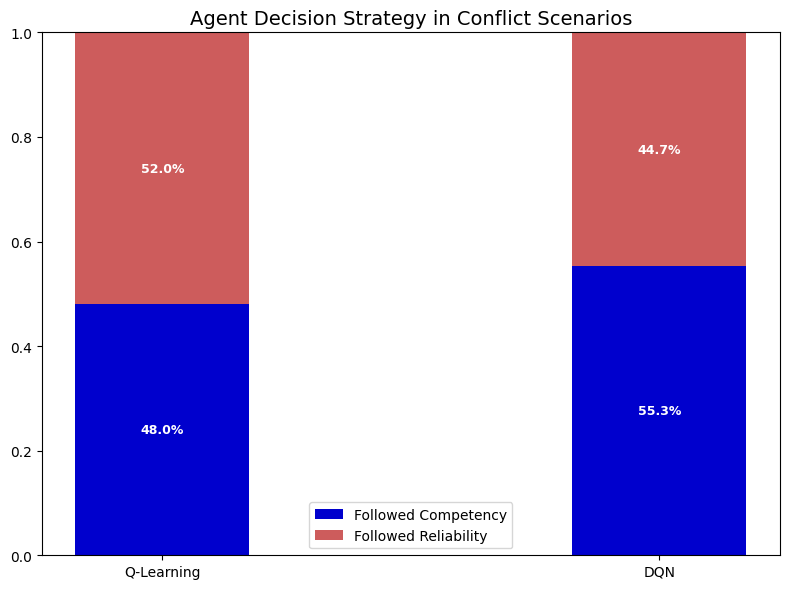

In [85]:
# --- Main Execution Block ---
if __name__ == "__main__":
    # Define the range of episodes you want to analyze
    ANALYSIS_START_EPISODE = 1
    ANALYSIS_END_EPISODE = 10 # Example: assuming you trained up to episode 10

    # --- Load logs for the original Q-Learning agent ---
    print(f"Loading Q-Learning logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    q_learning_logs = load_q_learning_logs(
        log_dir="train_log", # Your original Q-Learning log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded Q-Learning logs for {len(q_learning_logs)} episodes.")

    # --- Load logs for the DQN agent ---
    print(f"Loading DQN logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    dqn_logs = load_dqn_logs(
        log_dir="dqn_train_logs", # Your new DQN log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded DQN logs for {len(dqn_logs)} episodes.")

    # --- Analyze and Plot Conflict Strategy ---
    print("\nAnalyzing Q-Learning conflict strategy...")
    q_prop_comp, q_prop_rel, q_conflict_count = analyze_conflict_strategy(q_learning_logs, agent_type="Q-Learning")
    
    print("\nAnalyzing DQN conflict strategy...")
    dqn_prop_comp, dqn_prop_rel, dqn_conflict_count = analyze_conflict_strategy(dqn_logs, agent_type="DQN")

    # Combine proportions and counts for plotting
    q_learning_proportions = (q_prop_comp, q_prop_rel)
    dqn_proportions = (dqn_prop_comp, dqn_prop_rel)

    plot_conflict_strategy_proportions(q_learning_proportions, dqn_proportions, q_conflict_count, dqn_conflict_count)

In [100]:
# --- New Function to Analyze Integration Strategy (Simplified) ---
def analyze_integration_strategy(all_agent_logs, agent_type="DQN"):
    """
    Analyzes whether an agent's choices align more with an additive or multiplicative
    integration of competency and reliability, specifically in trials where these
    two models disagree on the optimal choice. The 'neither' category is removed,
    as the agent must choose one in conflict trials.

    Args:
        all_agent_logs (dict): Dictionary of loaded episode logs for one agent type.
        agent_type (str): "DQN" or "Q-Learning" to adjust log parsing.

    Returns:
        tuple: (proportion_followed_additive, proportion_followed_multiplicative, total_relevant_trials)
               or (0, 0, 0) if no relevant trials found.
    """
    is_dqn_log = (agent_type.lower() == "dqn")

    followed_additive_count = 0
    followed_multiplicative_count = 0
    total_relevant_trials = 0 # Trials where additive and multiplicative models disagree

    # A small epsilon for floating point comparisons to handle near-zero differences or ties
    epsilon = 1e-9 

    for ep_num in sorted(all_agent_logs.keys()):
        trial_log = all_agent_logs.get(ep_num)
        if not trial_log:
            continue

        for trial_data in trial_log:
            if is_dqn_log:
                state_list = trial_data['state']
                agent_action = trial_data['action'] # 0 for Left, 1 for Right
            else:
                state_list = trial_data[0]
                agent_action = trial_data[1] # 0 for Left, 1 for Right

            left_comp, left_rel, right_comp, right_rel = state_list

            # Calculate additive and multiplicative values for each eel
            left_add_val = left_comp + left_rel
            right_add_val = right_comp + right_rel
            left_mult_val = left_comp * left_rel
            right_mult_val = right_comp * right_rel

            # Determine optimal choice according to each model, handling ties with epsilon
            add_optimal_choice = None
            if left_add_val > right_add_val + epsilon:
                add_optimal_choice = 0 # Left
            elif right_add_val > left_add_val + epsilon:
                add_optimal_choice = 1 # Right

            mult_optimal_choice = None
            if left_mult_val > right_mult_val + epsilon:
                mult_optimal_choice = 0 # Left
            elif right_mult_val > left_mult_val + epsilon:
                mult_optimal_choice = 1 # Right

            # Analyze only if both models have a distinct optimal choice AND they disagree
            if add_optimal_choice is not None and mult_optimal_choice is not None and \
               add_optimal_choice != mult_optimal_choice:
                
                total_relevant_trials += 1
                
                # Agent must choose one of the two predictions if they conflict
                if agent_action == add_optimal_choice:
                    followed_additive_count += 1
                elif agent_action == mult_optimal_choice:
                    followed_multiplicative_count += 1
                # No 'neither' here, as agent_action must be 0 or 1, matching one of the distinct optimal choices
    
    if total_relevant_trials == 0:
        print(f"No trials found where additive and multiplicative models had distinct and conflicting optimal predictions for {agent_type} agent.")
        return 0, 0, 0 # prop_add, prop_mult, total_count

    prop_followed_additive = followed_additive_count / total_relevant_trials
    prop_followed_multiplicative = followed_multiplicative_count / total_relevant_trials
    # Ensure proportions sum to 1, accounting for any minor float precision issues or if 'neither' implicitly occurred
    # In a perfect binary scenario, prop_followed_additive + prop_followed_multiplicative should be 1
    
    return prop_followed_additive, prop_followed_multiplicative, total_relevant_trials

# --- New Function to Plot Integration Strategy Proportions (Simplified) ---
def plot_integration_strategy_proportions(q_learning_results, dqn_results):
    """
    Plots a stacked bar chart showing the proportion of times Q-Learning and DQN agents
    followed additive vs. multiplicative models in trials where these models disagreed.
    The 'neither' category is excluded.
    """
    labels = ['Q-Learning', 'DQN']
    
    q_add_prop, q_mult_prop, q_total_count = q_learning_results
    dqn_add_prop, dqn_mult_prop, dqn_total_count = dqn_results

    add_proportions = [q_add_prop, dqn_add_prop]
    mult_proportions = [q_mult_prop, dqn_mult_prop]
    
    # Ensure proportions sum to 1 in the bar chart by normalizing if needed
    # (though they should already if the logic is correct)
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # Stacked bars
    bar_add = ax.bar(labels, add_proportions, width=0.4, label='Followed Additive Model', color='mediumblue')
    bar_mult = ax.bar(labels, mult_proportions, width=0.4, bottom=add_proportions, label='Followed Multiplicative Model', color='indianred')
    
    ax.set_ylabel('Disagreement Trials', fontsize=12)
    ax.set_title('Agent Decision Strategy: Additive vs. Multiplicative Integration', fontsize=14)
    ax.set_ylim(0, 1) # Proportions go from 0 to 1
    ax.legend(fontsize=10)

    # Add percentage labels inside the bars
    for r1, r2 in zip(bar_add, bar_mult):
        h1 = r1.get_height()
        h2 = r2.get_height()

        if h1 > 0:
            ax.text(r1.get_x() + r1.get_width() / 2, h1 / 2, f'{h1:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold')
        if h2 > 0:
            ax.text(r2.get_x() + r2.get_width() / 2, h1 + h2 / 2, f'{h2:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold')

    plt.tight_layout()
    plt.show()
    plt.close()

Loading Q-Learning logs from episode 1 to 10...
Loaded Q-Learning logs for 10 episodes.
Loading DQN logs from episode 1 to 10...
Loaded DQN logs for 10 episodes.

Analyzing Q-Learning integration strategy...

Analyzing DQN integration strategy...


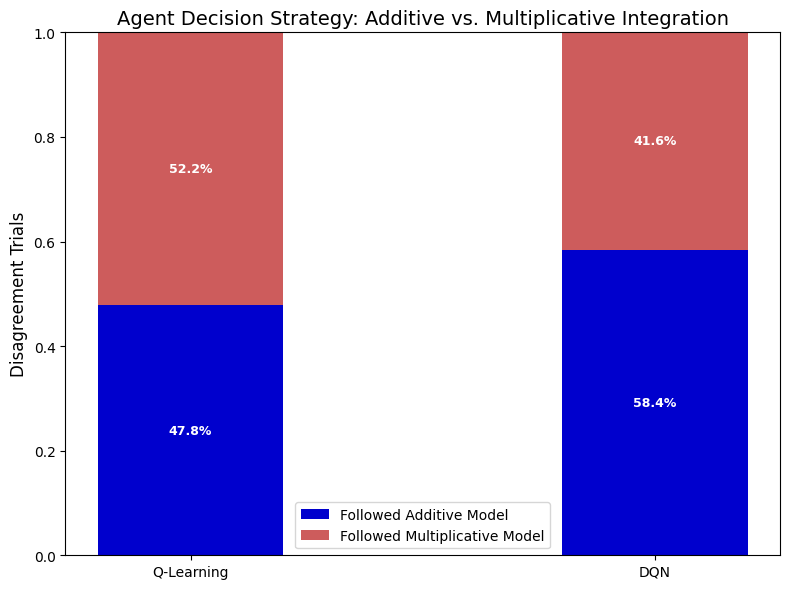

In [101]:
# --- Main Execution Block ---
if __name__ == "__main__":
    # Define the range of episodes you want to analyze
    ANALYSIS_START_EPISODE = 1
    ANALYSIS_END_EPISODE = 10 # Example: assuming you trained up to episode 10

    # --- Load logs for the original Q-Learning agent ---
    print(f"Loading Q-Learning logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    q_learning_logs = load_q_learning_logs(
        log_dir="train_log", # Your original Q-Learning log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded Q-Learning logs for {len(q_learning_logs)} episodes.")

    # --- Load logs for the DQN agent ---
    print(f"Loading DQN logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    dqn_logs = load_dqn_logs(
        log_dir="dqn_train_logs", # Your new DQN log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded DQN logs for {len(dqn_logs)} episodes.")

    # --- Analyze and Plot Integration Strategy ---
    print("\nAnalyzing Q-Learning integration strategy...")
    q_results = analyze_integration_strategy(q_learning_logs, agent_type="Q-Learning")
    
    print("\nAnalyzing DQN integration strategy...")
    dqn_results = analyze_integration_strategy(dqn_logs, agent_type="DQN")

    plot_integration_strategy_proportions(q_results, dqn_results)